# Imports

In [2]:
import brain_score_helper
from brain_score_helper import *
%reload_ext autoreload
#%load_ext autoreload
%autoreload 2

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [3]:
# Additional Functions

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from neuroai_kit.datasets import StreamingDataset
import neuroai_kit as nk

# Define the class at the module level.
class EmbedInBackground:
    def __init__(self, output_size, fill_color=(0, 0, 0)):
        self.output_size = output_size
        self.fill_color = fill_color

    def __call__(self, img, position=None):
        img_width, img_height = img.size
        bg_width, bg_height = self.output_size
        background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
        if position is None:
            x = (bg_width - img_width) // 2
            y = (bg_height - img_height) // 2
        else:
            x, y = position
        background.paste(img, (x, y))
        return background
# Assuming StreamingDataset is your custom dataset class
# from your_dataset_module import StreamingDataset

def load_data(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255), add_extra_dimension = False):
    # Mapping of normalization parameters for different image sizes
    norm_params = {
        384: {
            'mean': (0.48145466, 0.4578275, 0.40821073),
            'std': (0.26862954, 0.26130258, 0.27577711)
        },
        224: {
            'mean': (0.485, 0.456, 0.406),
            'std': (0.229, 0.224, 0.225)
        }
        # Add more sizes if needed
    }
    
    # Get parameters based on image_size; default to 384 if not found
    params = norm_params.get(image_size, norm_params[224])

    def data_transformations(image_size, add_extra_dimension=False):
        class EmbedInBackground:
            def __init__(self, output_size, fill_color=(0, 0, 0)):
                self.output_size = output_size
                self.fill_color = fill_color

            def __call__(self, img, position=None):
                img_width, img_height = img.size
                bg_width, bg_height = self.output_size
                background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
                if position is None:
                    x = (bg_width - img_width) // 2
                    y = (bg_height - img_height) // 2
                else:
                    x, y = position
                background.paste(img, (x, y))
                return background

    transforms_list = [
        # Optionally embed the image in a larger background
        EmbedInBackground((800, 800), fill_color=fill_color),
        # Resize to the required image_size using bicubic interpolation
        transforms.Resize(image_size, interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=params['mean'], std=params['std'])
    ]
    
    if add_extra_dimension:
        transforms_list += [
            lambda x: x[:, None, ...],
        ]
    
    image_transforms = transforms.Compose(transforms_list) 

    return image_transforms
   

def compute_model_rdm_from_corr(activations):
    """
    Compute a representational dissimilarity matrix (RDM) using 1 - np.corrcoef.

    Parameters:
      activations (np.ndarray or torch.Tensor): Array of shape (n_stimuli, features) or more.
    
    Returns:
      rdm (np.ndarray): Square RDM (n_stimuli x n_stimuli)
    """
    # If activations is a torch tensor, detach and convert to numpy.
    if isinstance(activations, torch.Tensor):
        activations = activations.detach().cpu().numpy()
        
    # If activations have more than 2 dimensions, flatten all but the first dimension.
    if activations.ndim > 2:
        activations = activations.reshape(activations.shape[0], -1)
        
    # Compute the correlation matrix between stimuli (each row is a stimulus)
    corr_mat = np.corrcoef(activations)  # shape: (n_stimuli, n_stimuli)
    
    # Compute dissimilarity as 1 - correlation
    rdm = 1 - corr_mat
    
    # Enforce symmetry and set the diagonal to zero
    rdm_sym = (rdm + rdm.T) / 2
    np.fill_diagonal(rdm_sym, 0)
    return rdm_sym


def compute_classical_rsa_from_activations(avg_brain_rdm, model_activations):
    """
    Compute classical RSA by comparing an average brain RDM to model RDMs computed from activations,
    where model RDMs are computed as 1 - np.corrcoef(activations).
    
    Parameters:
      avg_brain_rdm (np.ndarray): Average brain RDM (square matrix, shape: n_stimuli x n_stimuli)
      model_activations (dict): Dictionary {layer_name: activations} where each activations array is (n_stimuli, features)
    
    Returns:
      rsa_results (dict): Dictionary {layer_name: (r_value, p_value)} with RSA results for each layer.
    """
    # Process the average brain RDM: symmetrize and set diagonal to zero
    brain_rdm_sym = (avg_brain_rdm + avg_brain_rdm.T) / 2
    np.fill_diagonal(brain_rdm_sym, 0)
    # Convert the brain RDM to a 1D vector using squareform
    brain_rdm_vec = squareform(brain_rdm_sym)

    rsa_results = {}
    # Loop over each layer's activations
    for layer, acts in model_activations.items():
        # Compute the model RDM using 1 - np.corrcoef method
        model_rdm = compute_model_rdm_from_corr(acts)
        model_rdm_vec = squareform(model_rdm)
        
        if len(brain_rdm_vec) != len(model_rdm_vec):
            print(f"Skipping layer {layer}: Shape mismatch {len(brain_rdm_vec)} vs {len(model_rdm_vec)}")
            continue

        # Compute Pearson correlation between the flattened brain and model RDMs
        r_value, p_value = pearsonr(brain_rdm_vec, model_rdm_vec)
        rsa_results[layer] = (r_value, p_value)
    
    return rsa_results

def print_flattened_layers(model, prefix=""):
    # Loop over immediate children modules
    for name, module in model.named_children():
        full_name = prefix + name
        print(full_name, module)
        # Recursively print children modules
        print_flattened_layers(module, prefix=full_name + ".")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/lightning_sdk/helpers.py:48: UserWarning: A newer version of lightning-sdk is available (0.2.14). Please consider upgrading with `pip install -U lightning-sdk`. Not all platform functionality can be guaranteed to work with the current version.
  warnings.warn(


In [58]:
def load_data(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255), add_extra_dimension=False):
    # Normalization parameters
    norm_params = {
        384: {
            'mean': (0.48145466, 0.4578275, 0.40821073),
            'std': (0.26862954, 0.26130258, 0.27577711)
        },
        224: {
            'mean': (0.485, 0.456, 0.406),
            'std': (0.229, 0.224, 0.225)
        }
    }
    
    params = norm_params.get(image_size, norm_params[224])

    # Define the transformation pipeline.
    transforms_list = [
        EmbedInBackground((800, 800), fill_color=fill_color),
        transforms.Resize(image_size, interpolation=Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=params['mean'], std=params['std'])
    ]
    
    if add_extra_dimension:
        transforms_list.append(lambda x: x[:, None, ...])
    
    image_transforms = transforms.Compose(transforms_list) 

    # Apply the transformation to the dataset by wrapping it.
    dataset = StreamingDataset(dataset, transforms=image_transforms)
    
    # Determine an appropriate batch size.
    batch_size = batch_size if batch_size is not None else len(dataset)
    
    # Create a DataLoader to batch the dataset.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Retrieve the first batch of processed tensor images.
    img_batch = next(iter(dataloader))
    
    # If the returned batch is in dict form, adjust accordingly.
    if isinstance(img_batch, dict):
        img_batch = img_batch.get('image', img_batch)  # or adjust key as needed
    
    return img_batch


In [3]:
# import os
# from io import BytesIO
# from PIL import Image
# import torch
# import torchvision.transforms as transforms

# def load_data(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255), add_extra_dimension=False):
#     # Mapping of normalization parameters for different image sizes
#     norm_params = {
#         384: {
#             'mean': (0.48145466, 0.4578275, 0.40821073),
#             'std': (0.26862954, 0.26130258, 0.27577711)
#         },
#         224: {
#             'mean': (0.485, 0.456, 0.406),
#             'std': (0.229, 0.224, 0.225)
#         }
#         # Add more sizes if needed
#     }
    
#     # Get parameters based on image_size; default to 224 if not found
#     params = norm_params.get(image_size, norm_params[224])
    
#     # Define the helper class for embedding the image in a background.
#     class EmbedInBackground:
#         def __init__(self, output_size, fill_color=(0, 0, 0)):
#             self.output_size = output_size
#             self.fill_color = fill_color

#         def __call__(self, img, position=None):
#             img_width, img_height = img.size
#             bg_width, bg_height = self.output_size
#             background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
#             if position is None:
#                 x = (bg_width - img_width) // 2
#                 y = (bg_height - img_height) // 2
#             else:
#                 x, y = position
#             background.paste(img, (x, y))
#             return background

#     # Build the list of transformations
#     transforms_list = [
#         EmbedInBackground((800, 800), fill_color=fill_color),
#         transforms.Resize(image_size, interpolation=Image.BICUBIC),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=params['mean'], std=params['std'])
#     ]
    
#     if add_extra_dimension:
#         transforms_list.append(lambda x: x[:, None, ...])
    
#     image_transforms = transforms.Compose(transforms_list)

#     # Initialize an empty list to hold image tensors.
#     images = []
    
#     # Handle S3 or local filesystem
#     if dataset.startswith("s3://"):
#         # Parse the S3 bucket and prefix from the URL
#         # Example: s3://bucket-name/some/path/
#         s3_path = dataset[5:]  # remove "s3://"
#         parts = s3_path.split("/", 1)
#         bucket_name = parts[0]
#         prefix = parts[1] if len(parts) > 1 else ""
        
#         import boto3
#         s3 = boto3.client('s3')
        
#         # List objects under the prefix; note that this may need to be paginated for large datasets.
#         response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
#         if 'Contents' not in response:
#             raise RuntimeError("No objects found in S3 path: " + dataset)
        
#         image_keys = []
#         for obj in response['Contents']:
#             key = obj['Key']
#             if key.lower().endswith(('.png', '.jpg', '.jpeg')):
#                 image_keys.append(key)
#         # Optionally limit to batch_size
#         if batch_size is not None:
#             image_keys = image_keys[:batch_size]
        
#         # Download each image and apply transformation
#         for key in image_keys:
#             obj = s3.get_object(Bucket=bucket_name, Key=key)
#             file_stream = BytesIO(obj['Body'].read())
#             img = Image.open(file_stream).convert('RGB')
#             img_transformed = image_transforms(img)
#             images.append(img_transformed)
    
#     elif os.path.isdir(dataset):
#         # Local dataset: list all supported image files
#         image_files = [os.path.join(dataset, fname) for fname in os.listdir(dataset)
#                        if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
#         if batch_size is not None:
#             image_files = image_files[:batch_size]
#         for image_path in image_files:
#             img = Image.open(image_path).convert("RGB")
#             img_transformed = image_transforms(img)
#             images.append(img_transformed)
#     else:
#         raise ValueError("Dataset must be a local directory or a valid S3 path.")
    
#     # Make sure at least one image is loaded
#     if not images:
#         raise RuntimeError("No images were found in the given dataset path.")
    
#     # Stack images into a single tensor: [batch, channels, height, width]
#     images_tensor = torch.stack(images)
#     return images_tensor


# Top Avg Models : 1-5

## Loading model #1 and accessing without Pytorch wrapper

In [5]:
'''Model 1: convnext_large'''
convnext_large = load_model("convnext_large_mlp:clip_laion2b_augreg_ft_in1k_384")
convnext_large

Model convnext_large_mlp loaded


In [6]:
model_1 = convnext_large.activations_model._model
model_1

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=192, out_features=768, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=768, out_features=192, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [8]:
# from neuroai_kit.electrode import NeuroElectrodeArray

In [ ]:
# # getting layers flattened
# # Build the flattened list of layers to extract activations from:
# layers = []

# # 1. Add the stem layer
# layers.append('stem')
# #
# # 2. Add stages and block-level layers
# for stage_idx in range(4):  # stages 0, 1, 2, 3
#     stage_name = f"stages.{stage_idx}"
#     layers.append(stage_name)  # Include the whole stage if needed
    
#     # Determine the number of blocks: stage 2 has 27 blocks, others have 3 each.
#     num_blocks = 27 if stage_idx == 2 else 3
#     for block_idx in range(num_blocks):
#         block_prefix = f"{stage_name}.blocks.{block_idx}"
#         # Add key activation points from each block:
#         # MLP activation, normalization, and optionally the entire block output.
#         layers.append(f"{block_prefix}.mlp.act")
#         layers.append(f"{block_prefix}.norm")
#         layers.append(block_prefix)

# # 3. Add the head of the model
# layers.append('head')

# # Verify that each module exists in the model:
# model_modules = dict(model_1.named_modules())
# for layer in layers:
#     if layer not in model_modules:
#         print(f"Warning: {layer} not found in the model!")
#     # You could also choose to remove it or handle it differently if needed.

# # Create an input tensor for testing (e.g., a random image tensor of size 224x224)
# input_tensor = torch.randn(1, 3, 224, 224)

# # Use NeuroElectrodeArray to extract activations from the specified layers:
# with NeuroElectrodeArray(model_1, layers=layers) as electrode:
#     activations = electrode(input_tensor)

# # Print the activation shapes for verification:
# for layer_name, activation in activations.items():
#     print(f"Layer: {layer_name}, Shape: {activation.shape}")


Layer: stem, Shape: torch.Size([1, 192, 56, 56])
Layer: stages.0, Shape: torch.Size([1, 192, 56, 56])
Layer: stages.0.blocks.0.mlp.act, Shape: torch.Size([1, 56, 56, 768])
Layer: stages.0.blocks.0.norm, Shape: torch.Size([1, 56, 56, 192])
Layer: stages.0.blocks.0, Shape: torch.Size([1, 192, 56, 56])
Layer: stages.0.blocks.1.mlp.act, Shape: torch.Size([1, 56, 56, 768])
Layer: stages.0.blocks.1.norm, Shape: torch.Size([1, 56, 56, 192])
Layer: stages.0.blocks.1, Shape: torch.Size([1, 192, 56, 56])
Layer: stages.0.blocks.2.mlp.act, Shape: torch.Size([1, 56, 56, 768])
Layer: stages.0.blocks.2.norm, Shape: torch.Size([1, 56, 56, 192])
Layer: stages.0.blocks.2, Shape: torch.Size([1, 192, 56, 56])
Layer: stages.1, Shape: torch.Size([1, 384, 28, 28])
Layer: stages.1.blocks.0.mlp.act, Shape: torch.Size([1, 28, 28, 1536])
Layer: stages.1.blocks.0.norm, Shape: torch.Size([1, 28, 28, 384])
Layer: stages.1.blocks.0, Shape: torch.Size([1, 384, 28, 28])
Layer: stages.1.blocks.1.mlp.act, Shape: torch.S

Picking layers with random tensors instead of imgs!

In [10]:
# only stages activations

# Specify only the high-level layers to extract activations from:
layers = ['stem', 'stages.0', 'stages.1', 'stages.2', 'stages.3', 'head']

# Verify that each module exists in the model:
model_modules = dict(model_1.named_modules())
for layer in layers:
    if layer not in model_modules:
        print(f"Warning: {layer} not found in the model!")

# Create an input tensor for testing (e.g., a random image tensor of size 224x224)
input_tensor = torch.randn(1, 3, 224, 224)

# Use NeuroElectrodeArray (or your chosen activation extraction tool) to get activations:
with NeuroElectrodeArray(model_1, layers=layers) as electrode:
    activations = electrode(input_tensor)

# Print the activation shapes for verification:
for layer_name, activation in activations.items():
    print(f"Layer: {layer_name}, Shape: {activation.shape}")


Layer: stem, Shape: torch.Size([1, 192, 56, 56])
Layer: stages.0, Shape: torch.Size([1, 192, 56, 56])
Layer: stages.1, Shape: torch.Size([1, 384, 28, 28])
Layer: stages.2, Shape: torch.Size([1, 768, 14, 14])
Layer: stages.3, Shape: torch.Size([1, 1536, 7, 7])
Layer: head, Shape: torch.Size([1, 1000])


Checking Image size

In [4]:
# checking image size using timm
import timm 
timm.__version__
data_config = timm.data.resolve_model_data_config(model_1)
data_config


{'input_size': (3, 384, 384),
 'interpolation': 'bicubic',
 'mean': (0.48145466, 0.4578275, 0.40821073),
 'std': (0.26862954, 0.26130258, 0.27577711),
 'crop_pct': 1.0,
 'crop_mode': 'squash'}

In [9]:
# from PIL import Image
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader
# from neuroai_kit.datasets import StreamingDataset

# # Assuming StreamingDataset is your custom dataset class
# # from your_dataset_module import StreamingDataset

# def load_data(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255)):
#     # Mapping of normalization parameters for different image sizes
#     norm_params = {
#         384: {
#             'mean': (0.48145466, 0.4578275, 0.40821073),
#             'std': (0.26862954, 0.26130258, 0.27577711)
#         },
#         224: {
#             'mean': (0.485, 0.456, 0.406),
#             'std': (0.229, 0.224, 0.225)
#         }
#         # Add more sizes if needed
#     }
    
#     # Get parameters based on image_size; default to 384 if not found
#     params = norm_params.get(image_size, norm_params[224])
    
#     # Define the transformation pipeline with the desired image size and normalization.
#     def data_transformations(image_size):
#         class EmbedInBackground:
#             def __init__(self, output_size, fill_color=(0, 0, 0)):
#                 self.output_size = output_size
#                 self.fill_color = fill_color

#             def __call__(self, img, position=None):
#                 img_width, img_height = img.size
#                 bg_width, bg_height = self.output_size
#                 background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
#                 if position is None:
#                     x = (bg_width - img_width) // 2
#                     y = (bg_height - img_height) // 2
#                 else:
#                     x, y = position
#                 background.paste(img, (x, y))
#                 return background

#         return transforms.Compose([
#             # Optionally embed the image in a larger background
#             EmbedInBackground((800, 800), fill_color=fill_color),
#             # Resize to the required image_size using bicubic interpolation
#             transforms.Resize(image_size, interpolation=Image.BICUBIC),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=params['mean'], std=params['std'])
#         ])
    
#     # Build the transformation using the provided image_size
#     transform = data_transformations(image_size)
    
#     # Create the dataset using your custom StreamingDataset (or any dataset class)
#     dataset = StreamingDataset(dataset, transforms=transform)
    
#     # Determine the batch size; if not provided, use the full dataset size
#     batch_size = batch_size if batch_size else len(dataset)
    
#     # Create a DataLoader to get the batch(es)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
#     # Retrieve the first batch (or iterate over the dataloader as needed)
#     img_batch = next(iter(dataloader))
    
#     # If the returned batch is a dict (with images under a specific key), adjust accordingly.
#     if isinstance(img_batch, dict):
#         img_batch = img_batch['image']  # adjust key if needed
    
#     return img_batch


Loading normalized images

In [16]:
# load normalized images

dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=384)


In [17]:
import neuroai_kit as nk

layers = ['stem', 'stages.0', 'stages.1', 'stages.2', 'stages.3', 'head']

model_1.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_1, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

stem torch.Size([72, 192, 96, 96])
stages.0 torch.Size([72, 192, 96, 96])
stages.1 torch.Size([72, 384, 48, 48])
stages.2 torch.Size([72, 768, 24, 24])
stages.3 torch.Size([72, 1536, 12, 12])
head torch.Size([72, 1000])


In [18]:
# saving activations
torch.save(activations,"model_1_activations_stages.pt" )

In [20]:

# def compute_model_rdm_from_corr(activations):
#     """
#     Compute a representational dissimilarity matrix (RDM) using 1 - np.corrcoef.
    
#     Parameters:
#       activations (np.ndarray): Array of shape (n_stimuli, features) or more.
    
#     Returns:
#       rdm (np.ndarray): Square RDM (n_stimuli x n_stimuli)
#     """
#     # If activations have more than 2 dimensions, flatten all but the first dimension.
#     if activations.ndim > 2:
#         activations = activations.reshape(activations.shape[0], -1)
        
#     # Compute the correlation matrix between stimuli (each row is a stimulus)
#     corr_mat = np.corrcoef(activations)  # shape: (n_stimuli, n_stimuli)
#     # Compute dissimilarity as 1 - correlation
#     rdm = 1 - corr_mat
#     # Enforce symmetry and set the diagonal to zero
#     rdm_sym = (rdm + rdm.T) / 2
#     np.fill_diagonal(rdm_sym, 0)
#     return rdm_sym


# def compute_classical_rsa_from_activations(avg_brain_rdm, model_activations):
#     """
#     Compute classical RSA by comparing an average brain RDM to model RDMs computed from activations,
#     where model RDMs are computed as 1 - np.corrcoef(activations).
    
#     Parameters:
#       avg_brain_rdm (np.ndarray): Average brain RDM (square matrix, shape: n_stimuli x n_stimuli)
#       model_activations (dict): Dictionary {layer_name: activations} where each activations array is (n_stimuli, features)
    
#     Returns:
#       rsa_results (dict): Dictionary {layer_name: (r_value, p_value)} with RSA results for each layer.
#     """
#     # Process the average brain RDM: symmetrize and set diagonal to zero
#     brain_rdm_sym = (avg_brain_rdm + avg_brain_rdm.T) / 2
#     np.fill_diagonal(brain_rdm_sym, 0)
#     # Convert the brain RDM to a 1D vector using squareform
#     brain_rdm_vec = squareform(brain_rdm_sym)

#     rsa_results = {}
#     # Loop over each layer's activations
#     for layer, acts in model_activations.items():
#         # Compute the model RDM using 1 - np.corrcoef method
#         model_rdm = compute_model_rdm_from_corr(acts)
#         model_rdm_vec = squareform(model_rdm)
        
#         if len(brain_rdm_vec) != len(model_rdm_vec):
#             print(f"Skipping layer {layer}: Shape mismatch {len(brain_rdm_vec)} vs {len(model_rdm_vec)}")
#             continue

#         # Compute Pearson correlation between the flattened brain and model RDMs
#         r_value, p_value = pearsonr(brain_rdm_vec, model_rdm_vec)
#         rsa_results[layer] = (r_value, p_value)
    
#     return rsa_results

# Visualizing rdms for model

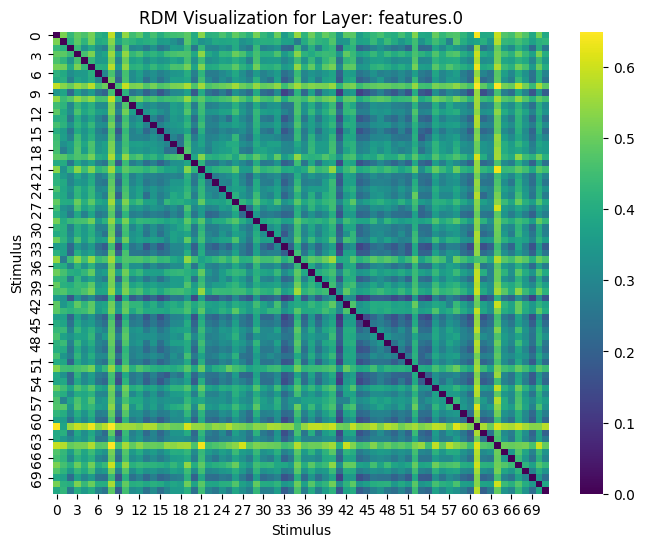

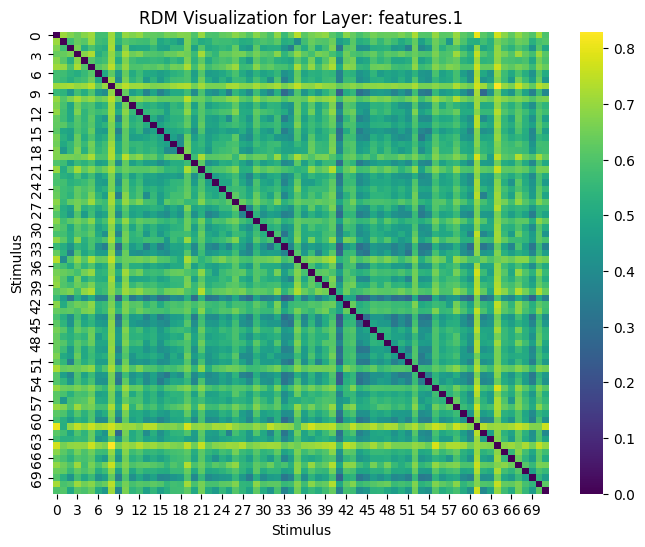

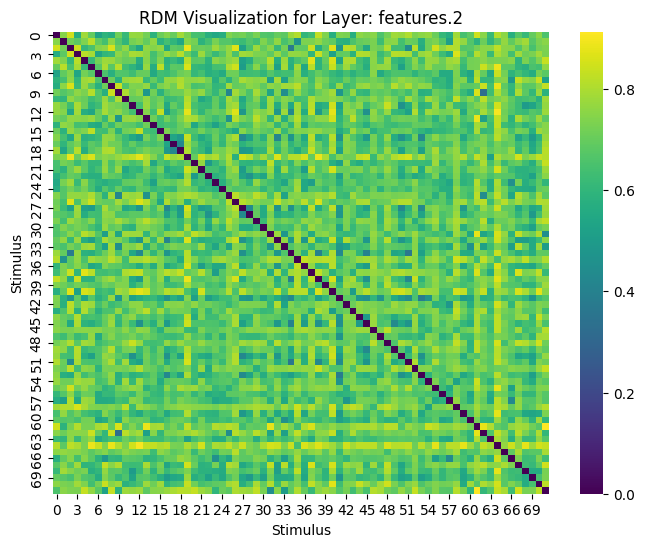

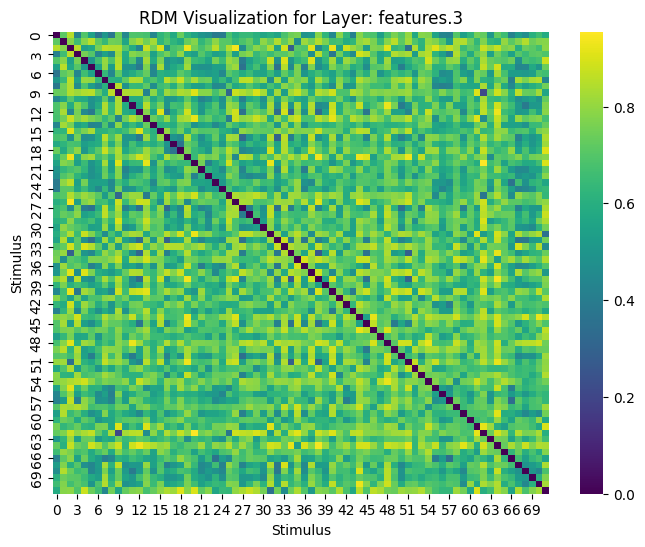

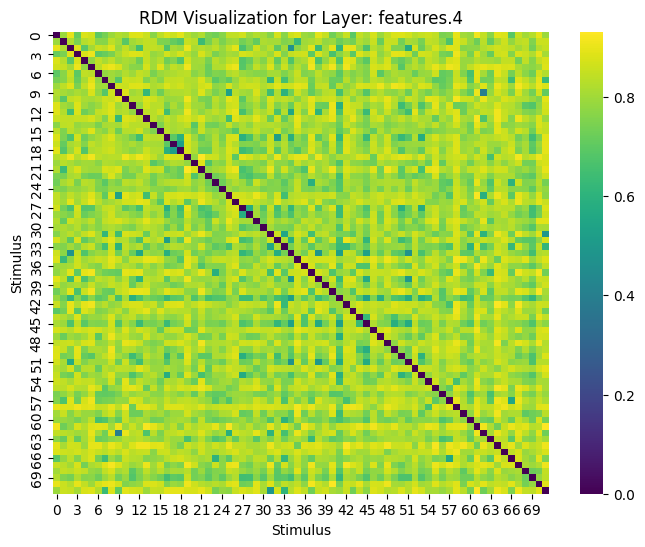

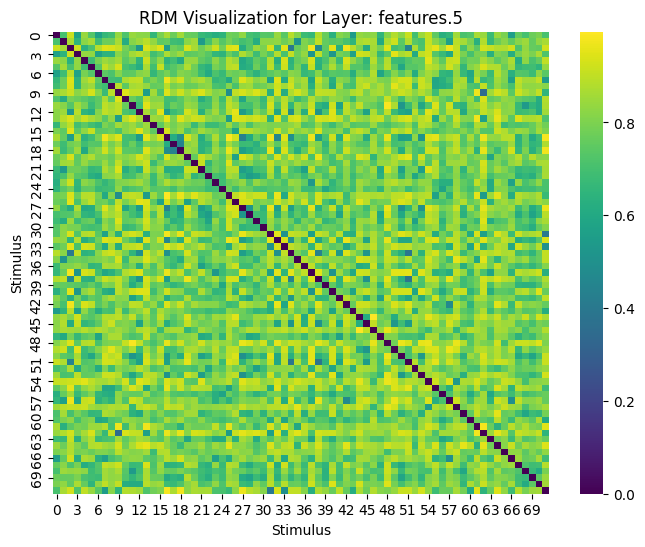

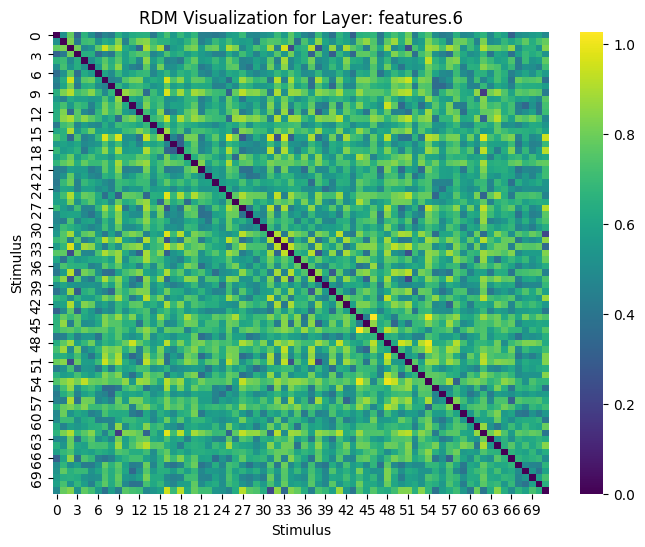

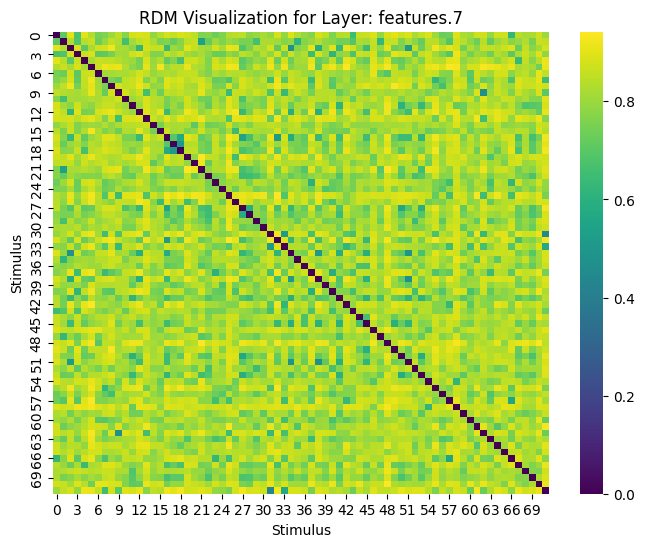

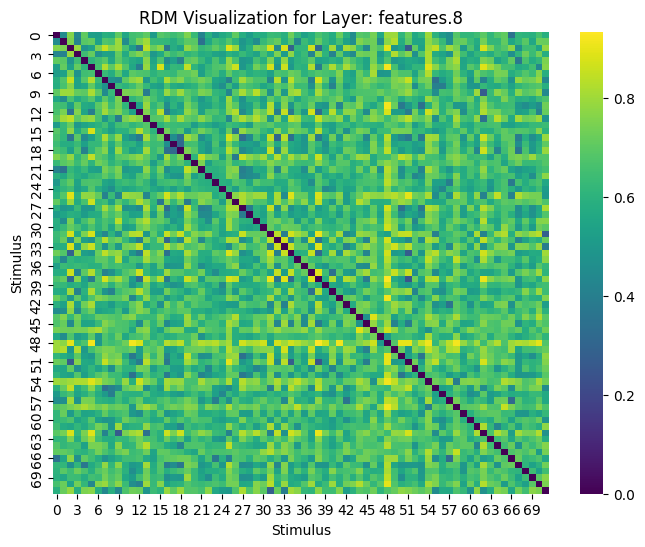

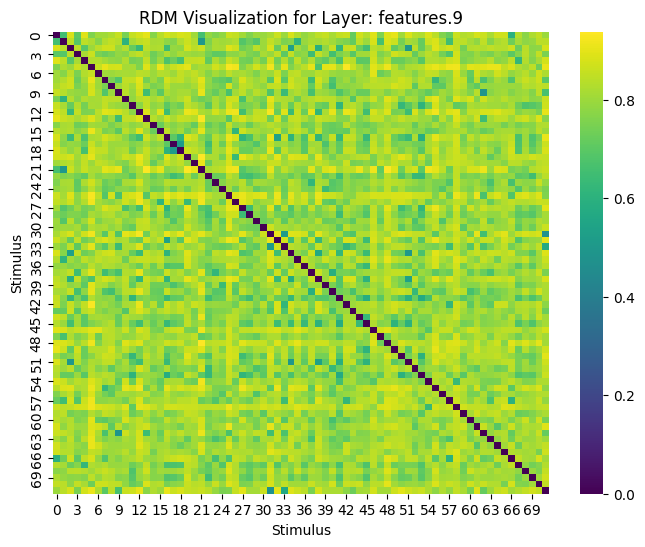

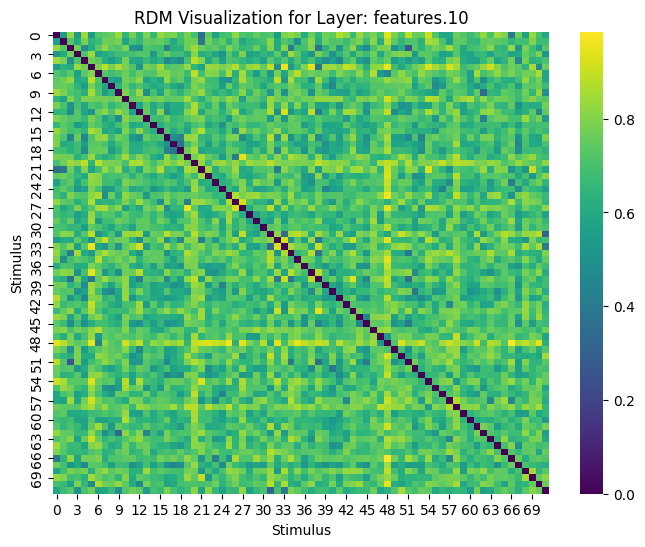

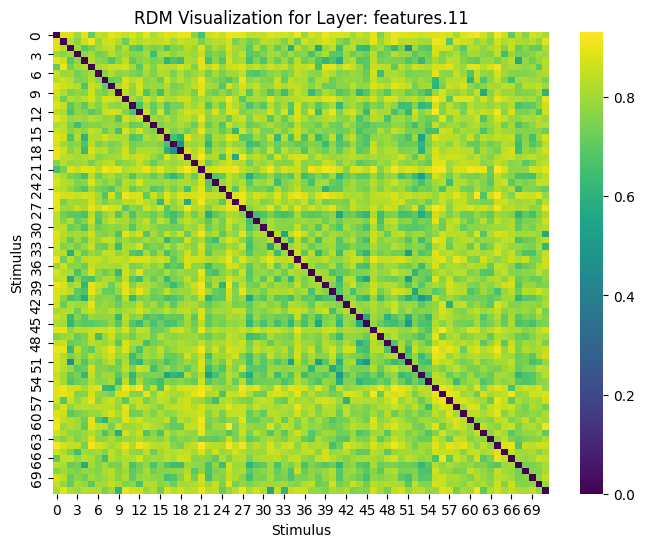

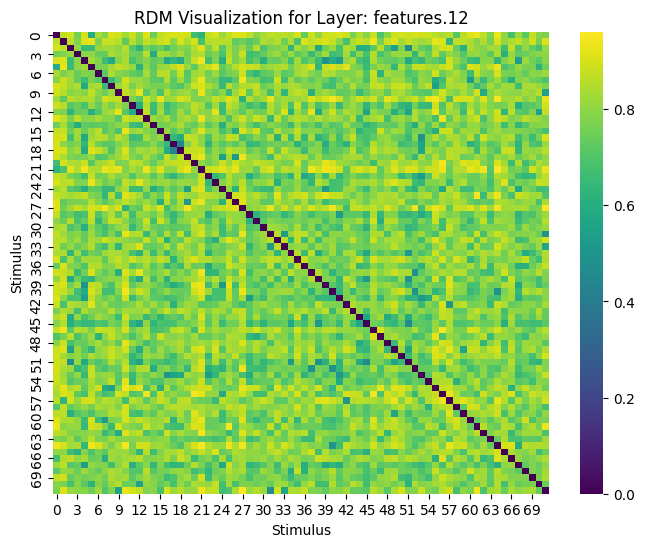

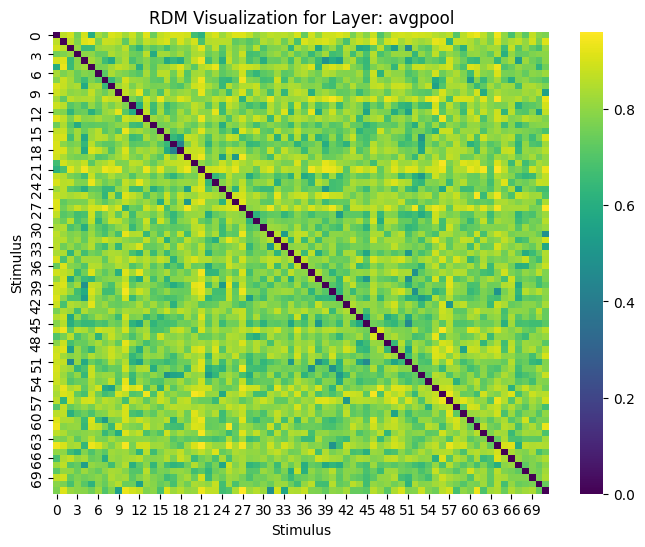

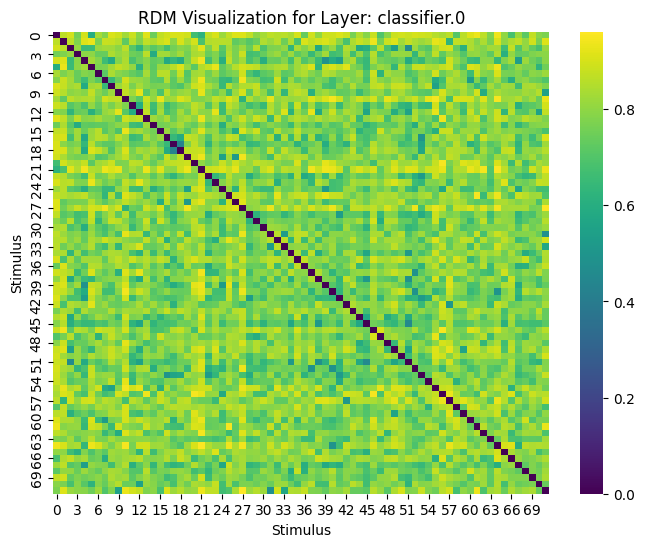

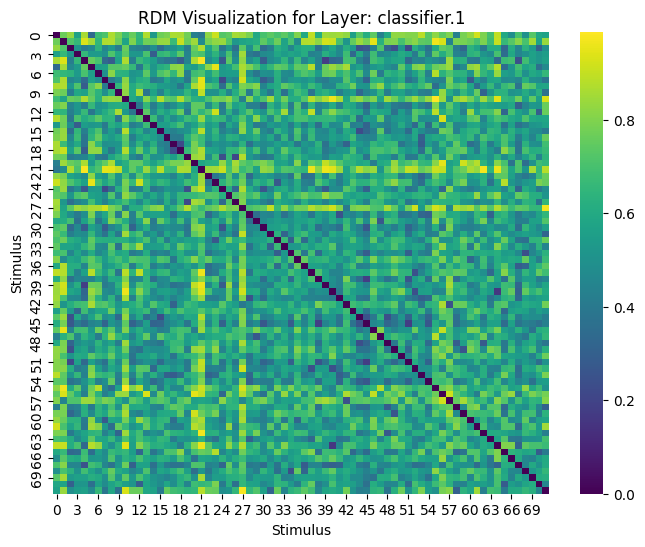

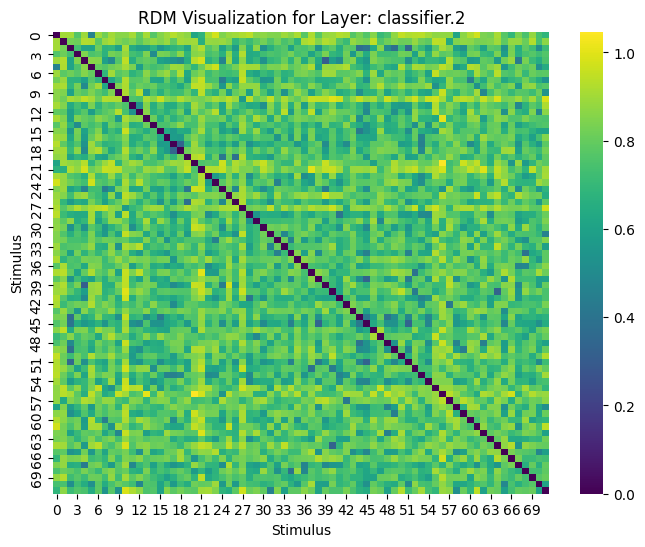

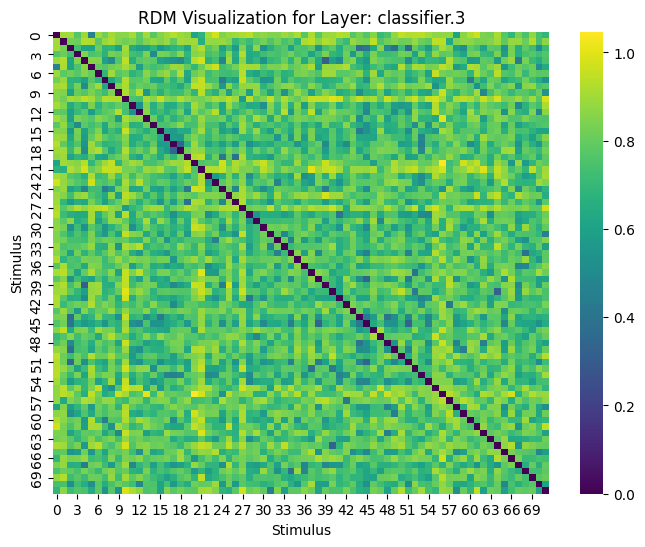

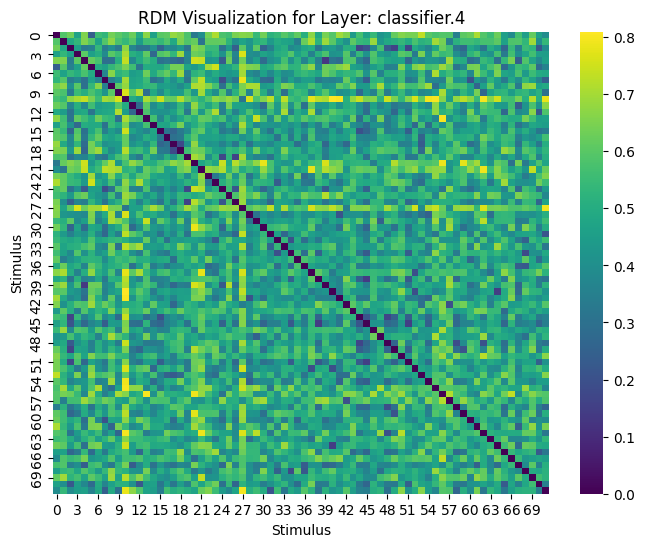

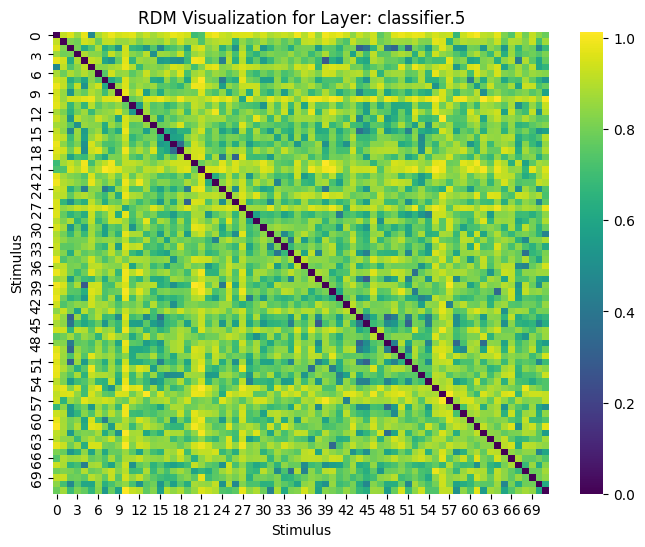

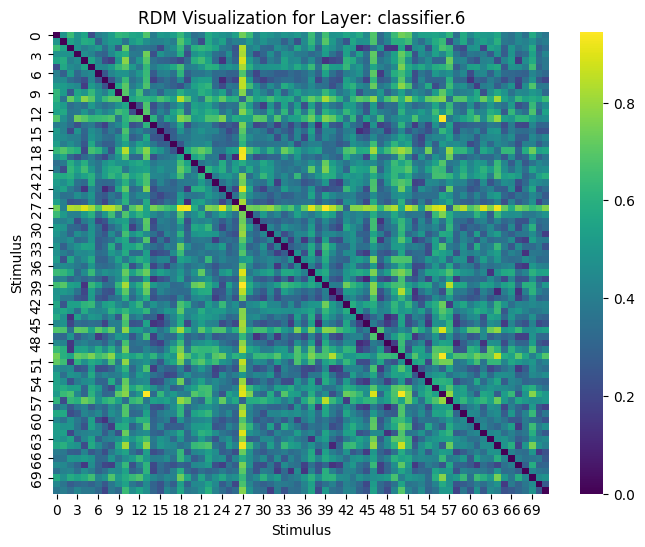

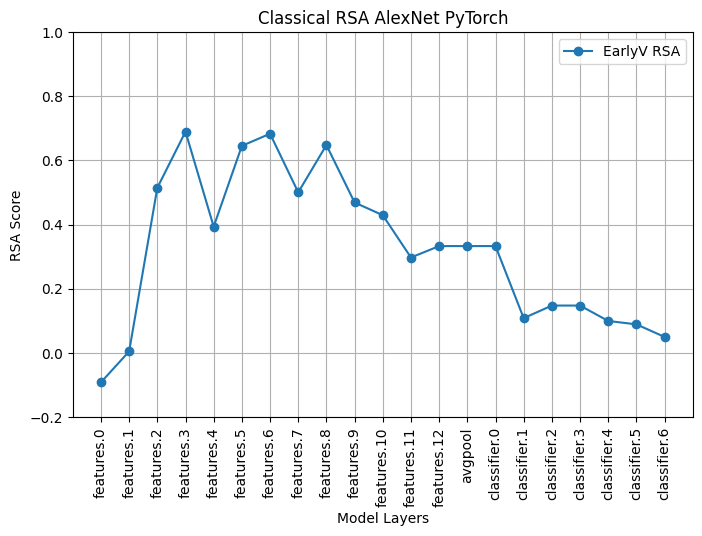

In [5]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import seaborn as sns

# Load activations
activations = torch.load('alexnet_pytorch_all_activations.pt')

# Specify ROIs
rois = ['EarlyV']  # List of ROIs (could be extended)
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Now, let's visualize the RDMs for the model (before calculating RSA)

# Assuming activations is a dictionary of layers with shapes like (batch_size, features)
def plot_rdm_for_layer(layer_activations, layer_name):
    # Compute the RDM by calculating pairwise distances (e.g., cosine distance)
    # Flatten the activations into a 2D array (samples, features)
    flattened_activations = layer_activations.view(layer_activations.size(0), -1)  # (n_samples, n_features)
    
    # Compute the pairwise distance (you can use cosine distance, Euclidean, etc.)
    rdm = 1 - np.corrcoef(flattened_activations.detach().cpu().numpy())  # Cosine distance (1 - correlation)
    
    # Visualize the RDM using a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(rdm, cmap='viridis', annot=False, cbar=True)
    plt.title(f'RDM Visualization for Layer: {layer_name}')
    plt.xlabel('Stimulus')
    plt.ylabel('Stimulus')
    plt.show()

# Plot RDMs for each layer in the model
for layer_name, layer_activations in activations.items():
    plot_rdm_for_layer(layer_activations, layer_name)

# Now create a single figure for RSA results across layers
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])

    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 1)
plt.title("Classical RSA AlexNet PyTorch")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


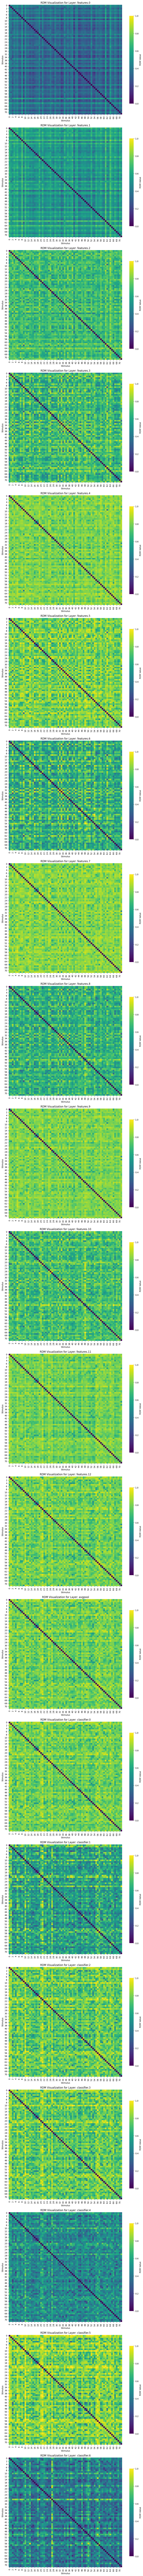

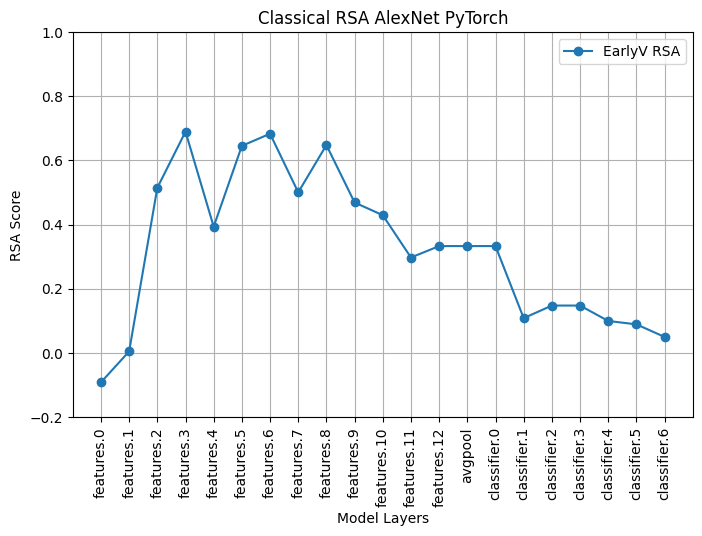

In [6]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import seaborn as sns

# Load activations
activations = torch.load('alexnet_pytorch_all_activations.pt')

# Specify ROIs
rois = ['EarlyV']  # List of ROIs (could be extended)
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Function to plot all RDMs in one plot
def plot_all_rdms(activations):
    # Set up the figure with a single axis for all heatmaps
    fig, axes = plt.subplots(len(activations), 1, figsize=(10, len(activations) * 8))

    if len(activations) == 1:
        axes = [axes]  # Ensure it's iterable if there's only one plot

    # Define the colorbar limits
    vmin, vmax = 0, 1  # Set the limits of the colorbar (0 to 1)

    # Loop through each layer and plot the RDM
    for i, (layer_name, layer_activations) in enumerate(activations.items()):
        # Flatten the activations into a 2D array (samples, features)
        flattened_activations = layer_activations.view(layer_activations.size(0), -1)
        
        # Compute the pairwise distance (Cosine distance: 1 - correlation)
        rdm = 1 - np.corrcoef(flattened_activations.detach().cpu().numpy())

        # Plot the RDM using a heatmap on the current axis
        sns.heatmap(rdm, ax=axes[i], cmap='viridis', annot=False, cbar=True, cbar_kws={'shrink': 0.8, 'label': 'RDM Value'}, vmin=vmin, vmax=vmax)
        axes[i].set_title(f'RDM Visualization for Layer: {layer_name}')
        axes[i].set_xlabel('Stimulus')
        axes[i].set_ylabel('Stimulus')

    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Plot all RDMs for each layer in a single plot
plot_all_rdms(activations)

# Now create a single figure for RSA results across layers
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])

    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 1)
plt.title("Classical RSA AlexNet PyTorch")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


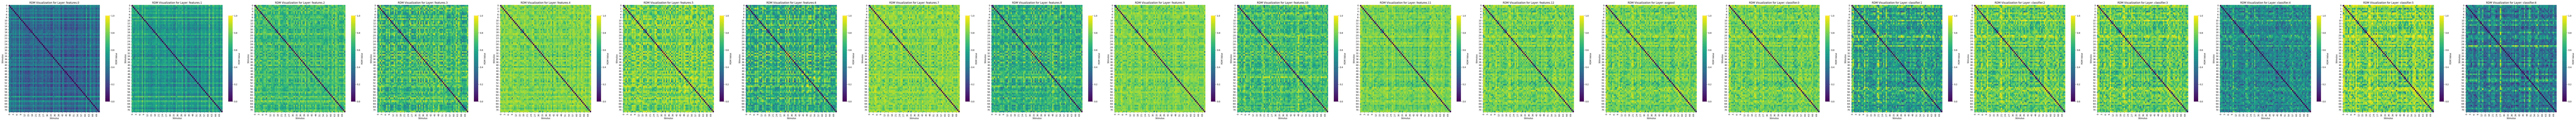

In [7]:
def plot_all_rdms(activations):
    # Set up the figure with a single row for all heatmaps
    fig, axes = plt.subplots(1, len(activations), figsize=(len(activations) * 8, 8))

    if len(activations) == 1:
        axes = [axes]  # Ensure it's iterable if there's only one plot

    # Define the colorbar limits
    vmin, vmax = 0, 1  # Set the limits of the colorbar (0 to 1)

    # Loop through each layer and plot the RDM
    for i, (layer_name, layer_activations) in enumerate(activations.items()):
        # Flatten the activations into a 2D array (samples, features)
        flattened_activations = layer_activations.view(layer_activations.size(0), -1)
        
        # Compute the pairwise distance (Cosine distance: 1 - correlation)
        rdm = 1 - np.corrcoef(flattened_activations.detach().cpu().numpy())

        # Plot the RDM using a heatmap on the current axis
        sns.heatmap(rdm, ax=axes[i], cmap='viridis', annot=False, cbar=True, cbar_kws={'shrink': 0.8, 'label': 'RDM Value'}, vmin=vmin, vmax=vmax)
        axes[i].set_title(f'RDM Visualization for Layer: {layer_name}')
        axes[i].set_xlabel('Stimulus')
        axes[i].set_ylabel('Stimulus')

    # Adjust the layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Plot all RDMs for each layer in a horizontal row
plot_all_rdms(activations)


# visualizing classical RSA across layers

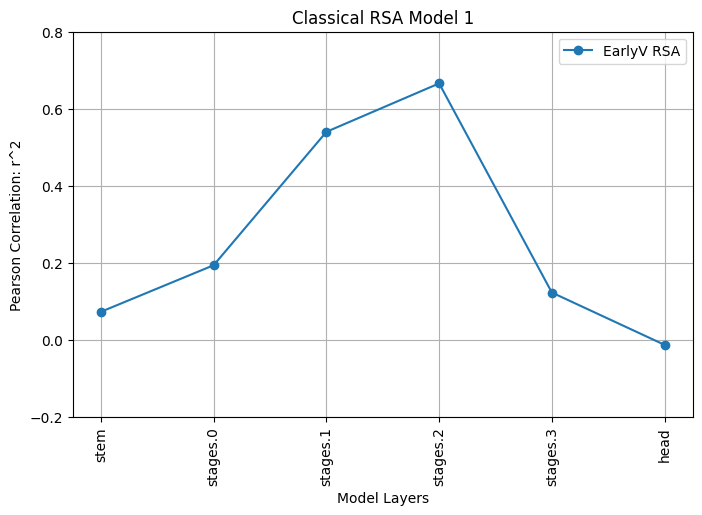

In [14]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_1_activations_stages.pt')


# Specifying ROIs
rois = ['EarlyV']
#, 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    #stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # # If the stop_layer is present, find its index and truncate the list
    # if stop_layer in layers:
    #     stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
    #     layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("Pearson Correlation: r^2")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA Model 1")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


In [13]:
import pickle
import numpy as np
import os
from scipy.spatial.distance import squareform

# Load activations
activations = torch.load('alexnet_pytorch_all_activations.pt')

# Specifying ROIs
rois = ['EarlyV']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Function to save RSA results as a pickle file
def save_rsa_results_as_pkl(rsa_results, model_name, roi_name):
    """
    Save the RSA results (dictionary) to a pickle file.
    
    Args:
        rsa_results: Dictionary containing RSA results with layers as keys.
        model_name: The model name (e.g., "alexnet").
        roi_name: The ROI name (e.g., "EarlyV").
    """
    base_folder = 'cRSA_models'
    
    # Ensure the base folder exists
    os.makedirs(base_folder, exist_ok=True)

    # Define the filename
    filename = f"{model_name}_{roi_name}_cRSA_results.pkl"
    file_path = os.path.join(base_folder, filename)
    
    # Save the RSA results as a pickle file
    with open(file_path, 'wb') as f:
        pickle.dump(rsa_results, f)
    
    print(f"RSA results saved as pickle file at: {file_path}")

# Save the RSA results (as a dictionary)
save_rsa_results_as_pkl(rsa_results, model_name="alexnet", roi_name="EarlyV")


RSA results saved as pickle file at: cRSA_models/alexnet_EarlyV_cRSA_results.pkl


In [12]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /teamspace/studios/this_studio


In [7]:
import os
import pickle

def save_plot_as_pkl(plt, model_name, roi_name):
    """
    Save the plot as a pickle file under cRSA_models folder.

    Args:
        plt: The plot object to save.
        model_name: The model name (e.g., "alexnet").
        roi_name: The ROI name (e.g., "EarlyV").
    """
    base_folder = 'cRSA_models'
    
    # Ensure the base folder exists
    os.makedirs(base_folder, exist_ok=True)

    # Define the filename
    filename = f"{model_name}_{roi_name}_cRSA_visual.pkl"
    file_path = os.path.join(base_folder, filename)
    
    # Save the plot as a pickle file
    with open(file_path, 'wb') as f:
        pickle.dump(plt, f)
    
    print(f"Plot saved as pickle file at: {file_path}")


In [ ]:
save_plot_as_pkl(plt, model_name, roi_name)

In [10]:
import neuroai_kit as nk


dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=384)

#  all layers
# getting layers flattened
# Build the flattened list of layers to extract activations from:
layers = []

# 1. Add the stem layer
layers.append('stem')
#
# 2. Add stages and block-level layers
for stage_idx in range(4):  # stages 0, 1, 2, 3
    stage_name = f"stages.{stage_idx}"
    layers.append(stage_name)  # Include the whole stage if needed
    
    # Determine the number of blocks: stage 2 has 27 blocks, others have 3 each.
    num_blocks = 27 if stage_idx == 2 else 3
    for block_idx in range(num_blocks):
        block_prefix = f"{stage_name}.blocks.{block_idx}"
        # Add key activation points from each block:
        # MLP activation, normalization, and optionally the entire block output.
        layers.append(f"{block_prefix}.mlp.act")
        layers.append(f"{block_prefix}.norm")
        layers.append(block_prefix)

# 3. Add the head of the model
layers.append('head')

# Verify that each module exists in the model:
model_modules = dict(model_1.named_modules())
for layer in layers:
    if layer not in model_modules:
        print(f"Warning: {layer} not found in the model!")
    # You could also choose to remove it or handle it differently if needed.

In [11]:

model_1.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_1, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)


: 

## Model # 2 from Brain Score: convNext_xlarge

In [7]:
# load model
from brainscore_vision import load_model
model = load_model("convnext_xlarge:fb_in22k_ft_in1k")

model.safetensors:   0%|          | 0.00/1.40G [00:00<?, ?B/s]

Model convnext_xlarge loaded


In [9]:

model_2 = model.activations_model._model
model_2

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((256,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=256)
          (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=256, out_features=1024, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=1024, out_features=256, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(256, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3),

In [10]:
import timm 
timm.__version__
data_config = timm.data.resolve_model_data_config(model_2)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875,
 'crop_mode': 'center'}

In [9]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from neuroai_kit.datasets import StreamingDataset

# Assuming StreamingDataset is your custom dataset class
# from your_dataset_module import StreamingDataset

def load_data(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255)):
    # Mapping of normalization parameters for different image sizes
    norm_params = {
        384: {
            'mean': (0.48145466, 0.4578275, 0.40821073),
            'std': (0.26862954, 0.26130258, 0.27577711)
        },
        224: {
            'mean': (0.485, 0.456, 0.406),
            'std': (0.229, 0.224, 0.225)
        }
        # Add more sizes if needed
    }
    
    # Get parameters based on image_size; default to 384 if not found
    params = norm_params.get(image_size, norm_params[224])
    
    # Define the transformation pipeline with the desired image size and normalization.
    def data_transformations(image_size):
        class EmbedInBackground:
            def __init__(self, output_size, fill_color=(0, 0, 0)):
                self.output_size = output_size
                self.fill_color = fill_color

            def __call__(self, img, position=None):
                img_width, img_height = img.size
                bg_width, bg_height = self.output_size
                background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
                if position is None:
                    x = (bg_width - img_width) // 2
                    y = (bg_height - img_height) // 2
                else:
                    x, y = position
                background.paste(img, (x, y))
                return background

        return transforms.Compose([
            # Optionally embed the image in a larger background
            EmbedInBackground((800, 800), fill_color=fill_color),
            # Resize to the required image_size using bicubic interpolation
            transforms.Resize(image_size, interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=params['mean'], std=params['std'])
        ])
    
    # Build the transformation using the provided image_size
    transform = data_transformations(image_size)
    
    # Create the dataset using your custom StreamingDataset (or any dataset class)
    dataset = StreamingDataset(dataset, transforms=transform)
    
    # Determine the batch size; if not provided, use the full dataset size
    batch_size = batch_size if batch_size else len(dataset)
    
    # Create a DataLoader to get the batch(es)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Retrieve the first batch (or iterate over the dataloader as needed)
    img_batch = next(iter(dataloader))
    
    # If the returned batch is a dict (with images under a specific key), adjust accordingly.
    if isinstance(img_batch, dict):
        img_batch = img_batch['image']  # adjust key if needed
    
    return img_batch


/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/lightning_sdk/helpers.py:48: UserWarning: A newer version of lightning-sdk is available (0.2.9). Please consider upgrading with `pip install -U lightning-sdk`. Not all platform functionality can be guaranteed to work with the current version.
  warnings.warn(


In [22]:
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

In [23]:
import torch

# Check that imgs is a torch.Tensor and has the correct shape: [batch_size, channels, height, width]
print("Input type:", type(imgs))
print("Input shape:", imgs.shape)


Input type: <class 'torch.Tensor'>
Input shape: torch.Size([72, 3, 224, 224])


In [24]:
import neuroai_kit as nk

layers = ['stem', 'stages.0', 'stages.1', 'stages.2', 'stages.3', 'head']

model_2.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_2, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

stem torch.Size([72, 256, 56, 56])
stages.0 torch.Size([72, 256, 56, 56])
stages.1 torch.Size([72, 512, 28, 28])
stages.2 torch.Size([72, 1024, 14, 14])
stages.3 torch.Size([72, 2048, 7, 7])
head torch.Size([72, 1000])


In [25]:
# saving activations
torch.save(activations,"model_2_activations_stages.pt" )

In [27]:

def compute_model_rdm_from_corr(activations):
    """
    Compute a representational dissimilarity matrix (RDM) using 1 - np.corrcoef.
    
    Parameters:
      activations (np.ndarray): Array of shape (n_stimuli, features) or more.
    
    Returns:
      rdm (np.ndarray): Square RDM (n_stimuli x n_stimuli)
    """
    # If activations have more than 2 dimensions, flatten all but the first dimension.
    if activations.ndim > 2:
        activations = activations.reshape(activations.shape[0], -1)
        
    # Compute the correlation matrix between stimuli (each row is a stimulus)
    corr_mat = np.corrcoef(activations)  # shape: (n_stimuli, n_stimuli)
    # Compute dissimilarity as 1 - correlation
    rdm = 1 - corr_mat
    # Enforce symmetry and set the diagonal to zero
    rdm_sym = (rdm + rdm.T) / 2
    np.fill_diagonal(rdm_sym, 0)
    return rdm_sym


def compute_classical_rsa_from_activations(avg_brain_rdm, model_activations):
    """
    Compute classical RSA by comparing an average brain RDM to model RDMs computed from activations,
    where model RDMs are computed as 1 - np.corrcoef(activations).
    
    Parameters:
      avg_brain_rdm (np.ndarray): Average brain RDM (square matrix, shape: n_stimuli x n_stimuli)
      model_activations (dict): Dictionary {layer_name: activations} where each activations array is (n_stimuli, features)
    
    Returns:
      rsa_results (dict): Dictionary {layer_name: (r_value, p_value)} with RSA results for each layer.
    """
    # Process the average brain RDM: symmetrize and set diagonal to zero
    brain_rdm_sym = (avg_brain_rdm + avg_brain_rdm.T) / 2
    np.fill_diagonal(brain_rdm_sym, 0)
    # Convert the brain RDM to a 1D vector using squareform
    brain_rdm_vec = squareform(brain_rdm_sym)

    rsa_results = {}
    # Loop over each layer's activations
    for layer, acts in model_activations.items():
        # Compute the model RDM using 1 - np.corrcoef method
        model_rdm = compute_model_rdm_from_corr(acts)
        model_rdm_vec = squareform(model_rdm)
        
        if len(brain_rdm_vec) != len(model_rdm_vec):
            print(f"Skipping layer {layer}: Shape mismatch {len(brain_rdm_vec)} vs {len(model_rdm_vec)}")
            continue

        # Compute Pearson correlation between the flattened brain and model RDMs
        r_value, p_value = pearsonr(brain_rdm_vec, model_rdm_vec)
        rsa_results[layer] = (r_value, p_value)
    
    return rsa_results

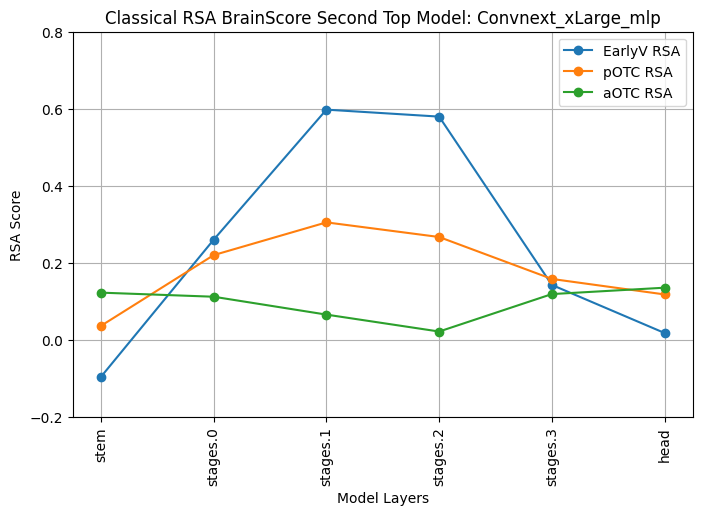

In [28]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_2_activations_stages.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Second Top Model: Convnext_xLarge_mlp")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model # 3: vit_base_patch_16

In [2]:
#from brainscore_vision import load_model
model = load_model("vit_base_patch16_clip_224:openai_ft_in12k_in1k")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model vit_base_patch16_clip_224 loaded


In [4]:
model_3 = model.activations_model._model
model_3

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): 

In [5]:
print(dir(model_3))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_init_weights', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_pos_embed', '_r

In [10]:
model_3.__class__

timm.models.vision_transformer.VisionTransformer

In [13]:
def print_flattened_layers(model, prefix=""):
    # Loop over immediate children modules
    for name, module in model.named_children():
        full_name = prefix + name
        print(full_name, module)
        # Recursively print children modules
        print_flattened_layers(module, prefix=full_name + ".")

# Use the function on your model:
print_flattened_layers(model_3)


patch_embed PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (norm): Identity()
)
patch_embed.proj Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
patch_embed.norm Identity()
pos_drop Dropout(p=0.0, inplace=False)
patch_drop Identity()
norm_pre LayerNorm((768,), eps=1e-05, elementwise_affine=True)
blocks Sequential(
  (0): Block(
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (q_norm): Identity()
      (k_norm): Identity()
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): Identity()
    (drop_path1): Identity()
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approxim

In [14]:
import timm 
timm.__version__
data_config = timm.data.resolve_model_data_config(model_3)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.48145466, 0.4578275, 0.40821073),
 'std': (0.26862954, 0.26130258, 0.27577711),
 'crop_pct': 0.95,
 'crop_mode': 'center'}

In [6]:
# this has 224 img size but different normalization!
'''Note: I am using different normalization for img 224'''

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from neuroai_kit.datasets import StreamingDataset

def load_data2(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255)):
    # Mapping of normalization parameters for different image sizes
    norm_params = {
        224: {
            'mean': (0.48145466, 0.4578275, 0.40821073),
            'std': (0.26862954, 0.26130258, 0.27577711)
         },
        # 224: {
        #     'mean': (0.485, 0.456, 0.406),
        #     'std': (0.229, 0.224, 0.225)
        # }
        # Add more sizes if needed
    }

    # Use the specified image_size or default to 384 if not found in mapping
    params = norm_params.get(image_size, norm_params[224])
    
    def data_transformations(image_size):
        class EmbedInBackground:
            def __init__(self, output_size, fill_color=(0, 0, 0)):
                self.output_size = output_size
                self.fill_color = fill_color

            def __call__(self, img, position=None):
                img_width, img_height = img.size
                bg_width, bg_height = self.output_size
                background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
                if position is None:
                    x = (bg_width - img_width) // 2
                    y = (bg_height - img_height) // 2
                else:
                    x, y = position
                background.paste(img, (x, y))
                return background

        return transforms.Compose([
            # Embeds the image in a larger background (optional)
            EmbedInBackground((800, 800), fill_color=fill_color),
            # Resize to the required image_size
            transforms.Resize(image_size, interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=params['mean'], std=params['std'])
        ])
    
    transform = data_transformations(image_size)
    # Here you would normally apply the transform to your dataset.
    # For now, we return the transform for demonstration.
     # Create the dataset using your custom StreamingDataset (or any dataset class)
    dataset = StreamingDataset(dataset, transforms=transform)
    
    # Determine the batch size; if not provided, use the full dataset size
    batch_size = batch_size if batch_size else len(dataset)
    
    # Create a DataLoader to get the batch(es)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Retrieve the first batch (or iterate over the dataloader as needed)
    img_batch = next(iter(dataloader))
    
    # If the returned batch is a dict (with images under a specific key), adjust accordingly.
    if isinstance(img_batch, dict):
        img_batch = img_batch['image']  # adjust key if needed
    
    return img_batch
    

In [26]:
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data2(dataset_path, image_size=224)

In [27]:
import neuroai_kit as nk

layers = [f"blocks.{i}" for i in range(12)]


model_3.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_3, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

blocks.0 torch.Size([72, 197, 768])
blocks.1 torch.Size([72, 197, 768])
blocks.2 torch.Size([72, 197, 768])
blocks.3 torch.Size([72, 197, 768])
blocks.4 torch.Size([72, 197, 768])
blocks.5 torch.Size([72, 197, 768])
blocks.6 torch.Size([72, 197, 768])
blocks.7 torch.Size([72, 197, 768])
blocks.8 torch.Size([72, 197, 768])
blocks.9 torch.Size([72, 197, 768])
blocks.10 torch.Size([72, 197, 768])
blocks.11 torch.Size([72, 197, 768])


In [28]:
torch.save(activations, "model_3_activations_blocks.pt")

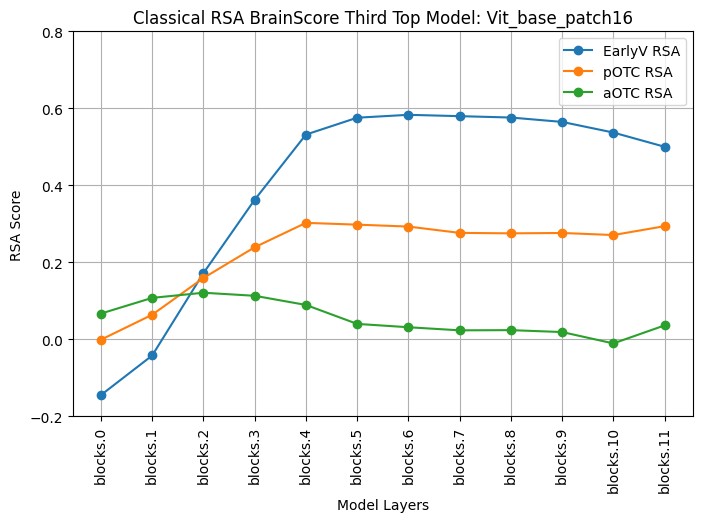

In [30]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_3_activations_blocks.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Third Top Model: Vit_base_patch16")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


# Top 3rd overall neural vision score: convnext_tiny_imagenetfull (50): 0.386 for neural and 0.461 for IT

In [8]:
from brainscore_vision import load_model
from brainscore_vision.models.scaling_models import MODEL_CONFIGS

model_name = "convnext_tiny_imagenet_full_seed-0"
MODEL_CONFIGS[model_name]

{'model_name': 'convnext_tiny',
 'model_id': 'convnext_tiny_imagenet_full_seed-0',
 'num_classes': 1000,
 'resize_size': 256,
 'crop_size': 224,
 'interpolation': 'bicubic',
 'load_model_ema': True,
 'use_timm': False,
 'timm_model_name': None,
 'is_vit': False,
 'epoch': 300,
 'output_head': 'model.classifier[2]',
 'model_commitment': {'layers': ['features.4.0',
   'features.5.4.block.0',
   'features.6.0'],
  'behavioral_readout_layer': 'classifier.1',
  'region_layer_map': {'V1': 'features.6.0',
   'V2': 'features.5.4.block.0',
   'V4': 'features.4.0',
   'IT': 'features.5.4.block.0'}},
 'checkpoint_url': 'https://epfl-neuroailab-scalinglaws.s3.eu-north-1.amazonaws.com/checkpoints/convnext_tiny_imagenet_full_seed-0/ep300.pt'}

In [9]:

model = load_model(model_name)
model

Model loaded from https://epfl-neuroailab-scalinglaws.s3.eu-north-1.amazonaws.com/checkpoints/convnext_tiny_imagenet_full_seed-0/ep300.pt


In [2]:
model.__class__

brainscore_vision.model_helpers.brain_transformation.ModelCommitment

In [ ]:
tmp = model.activations_model


In [3]:
convnext_tiny = model.activations_model._model
convnext_tiny

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [7]:
convnext_tiny.__class__

torchvision.models.convnext.ConvNeXt

In [21]:
convnext_tiny.resize_size

AttributeError: 'ConvNeXt' object has no attribute 'resize_size'

In [10]:
print(dir(convnext_tiny))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_impl', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_s

In [14]:
convnext_tiny.size

AttributeError: 'ConvNeXt' object has no attribute 'size'

# Loading dinov2 : not in brainscore!

In [2]:
import torch
# DINOv2
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

Using cache found in /home/zeus/.cache/torch/hub/facebookresearch_dinov2_main
/home/zeus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/zeus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/zeus/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /home/zeus/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:03<00:00, 332MB/s]


In [3]:
dinov2_vitl14

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [4]:
def print_flattened_layers(model, prefix=""):
    # Loop over immediate children modules
    for name, module in model.named_children():
        full_name = prefix + name
        print(full_name, module)
        # Recursively print children modules
        print_flattened_layers(module, prefix=full_name + ".")

# Use the function on your model:
print_flattened_layers(dinov2_vitl14)


patch_embed PatchEmbed(
  (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
  (norm): Identity()
)
patch_embed.proj Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
patch_embed.norm Identity()
blocks ModuleList(
  (0-23): 24 x NestedTensorBlock(
    (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (attn): MemEffAttention(
      (qkv): Linear(in_features=1024, out_features=3072, bias=True)
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=1024, out_features=1024, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): LayerScale()
    (drop_path1): Identity()
    (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (act): GELU(approximate='none')
      (fc2): Linear(in_features=4096, out_features=1024, bias=True)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (ls2): LayerScale()
    (drop_pa

In [10]:
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

In [11]:
dinov2_vitl14.eval()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [12]:
import neuroai_kit as nk
layers = [f"blocks.{i}" for i in range(24)]  # for the 12 blocks


dinov2_vitl14.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(dinov2_vitl14, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

blocks.0 torch.Size([72, 257, 1024])
blocks.1 torch.Size([72, 257, 1024])
blocks.2 torch.Size([72, 257, 1024])
blocks.3 torch.Size([72, 257, 1024])
blocks.4 torch.Size([72, 257, 1024])
blocks.5 torch.Size([72, 257, 1024])
blocks.6 torch.Size([72, 257, 1024])
blocks.7 torch.Size([72, 257, 1024])
blocks.8 torch.Size([72, 257, 1024])
blocks.9 torch.Size([72, 257, 1024])
blocks.10 torch.Size([72, 257, 1024])
blocks.11 torch.Size([72, 257, 1024])
blocks.12 torch.Size([72, 257, 1024])
blocks.13 torch.Size([72, 257, 1024])
blocks.14 torch.Size([72, 257, 1024])
blocks.15 torch.Size([72, 257, 1024])
blocks.16 torch.Size([72, 257, 1024])
blocks.17 torch.Size([72, 257, 1024])
blocks.18 torch.Size([72, 257, 1024])
blocks.19 torch.Size([72, 257, 1024])
blocks.20 torch.Size([72, 257, 1024])
blocks.21 torch.Size([72, 257, 1024])
blocks.22 torch.Size([72, 257, 1024])
blocks.23 torch.Size([72, 257, 1024])


In [13]:
# saving activations
torch.save(activations,"dino_large_block_activations.pt" )

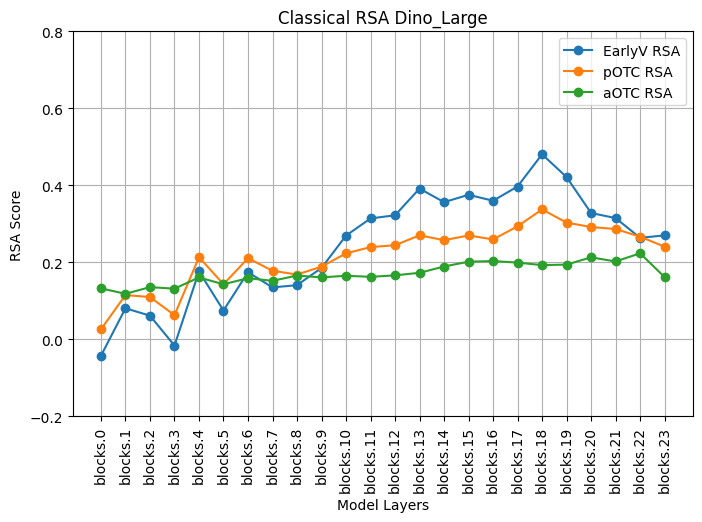

In [14]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('dino_large_block_activations.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA Dino_Large")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Rest of top avg models : 4, 5

In [14]:
# model 4
model = load_model("vit_large_patch14_clip_224:laion2b_ft_in1k")
model

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Model vit_large_patch14_clip_224 loaded


In [23]:
model_4 = model.activations_model._model
model_4



VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (

In [22]:
# Use the function on your model:
# print_flattened_layers(model_4)

patch_embed PatchEmbed(
  (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
  (norm): Identity()
)
patch_embed.proj Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
patch_embed.norm Identity()
pos_drop Dropout(p=0.0, inplace=False)
patch_drop Identity()
norm_pre LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
blocks Sequential(
  (0): Block(
    (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=1024, out_features=3072, bias=True)
      (q_norm): Identity()
      (k_norm): Identity()
      (attn_drop): Dropout(p=0.0, inplace=False)
      (proj): Linear(in_features=1024, out_features=1024, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (ls1): Identity()
    (drop_path1): Identity()
    (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=1024, out_features=4096, bias=True)
      (act): GELU

In [18]:
model_4.__class__

timm.models.vision_transformer.VisionTransformer

In [20]:
import timm 
timm.__version__
data_config = timm.data.resolve_model_data_config(model_4)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 1.0,
 'crop_mode': 'center'}

In [24]:
# this has 224 img size but different normalization!
'''Note: I am using different normalization for img 224'''

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from neuroai_kit.datasets import StreamingDataset

def load_data2(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255)):
    # Mapping of normalization parameters for different image sizes
    norm_params = {
        224: {
            'mean': (0.5, 0.5, 0.5),
            'std': (0.5, 0.5, 0.5)
         },
        # 224: {
        #     'mean': (0.485, 0.456, 0.406),
        #     'std': (0.229, 0.224, 0.225)
        # }
        # Add more sizes if needed
    }

    # Use the specified image_size or default to 384 if not found in mapping
    params = norm_params.get(image_size, norm_params[224])
    
    def data_transformations(image_size):
        class EmbedInBackground:
            def __init__(self, output_size, fill_color=(0, 0, 0)):
                self.output_size = output_size
                self.fill_color = fill_color

            def __call__(self, img, position=None):
                img_width, img_height = img.size
                bg_width, bg_height = self.output_size
                background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
                if position is None:
                    x = (bg_width - img_width) // 2
                    y = (bg_height - img_height) // 2
                else:
                    x, y = position
                background.paste(img, (x, y))
                return background

        return transforms.Compose([
            # Embeds the image in a larger background (optional)
            EmbedInBackground((800, 800), fill_color=fill_color),
            # Resize to the required image_size
            transforms.Resize(image_size, interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=params['mean'], std=params['std'])
        ])
    
    transform = data_transformations(image_size)
    # Here you would normally apply the transform to your dataset.
    # For now, we return the transform for demonstration.
     # Create the dataset using your custom StreamingDataset (or any dataset class)
    dataset = StreamingDataset(dataset, transforms=transform)
    
    # Determine the batch size; if not provided, use the full dataset size
    batch_size = batch_size if batch_size else len(dataset)
    
    # Create a DataLoader to get the batch(es)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Retrieve the first batch (or iterate over the dataloader as needed)
    img_batch = next(iter(dataloader))
    
    # If the returned batch is a dict (with images under a specific key), adjust accordingly.
    if isinstance(img_batch, dict):
        img_batch = img_batch['image']  # adjust key if needed
    
    return img_batch
    

In [28]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data2(dataset_path, image_size=224)

import neuroai_kit as nk

layers = [f"blocks.{i}" for i in range(24)] # 0- n-1, since there are 0-23 range is 24


model_4.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_4, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

blocks.0 torch.Size([72, 257, 1024])
blocks.1 torch.Size([72, 257, 1024])
blocks.2 torch.Size([72, 257, 1024])
blocks.3 torch.Size([72, 257, 1024])
blocks.4 torch.Size([72, 257, 1024])
blocks.5 torch.Size([72, 257, 1024])
blocks.6 torch.Size([72, 257, 1024])
blocks.7 torch.Size([72, 257, 1024])
blocks.8 torch.Size([72, 257, 1024])
blocks.9 torch.Size([72, 257, 1024])
blocks.10 torch.Size([72, 257, 1024])
blocks.11 torch.Size([72, 257, 1024])
blocks.12 torch.Size([72, 257, 1024])
blocks.13 torch.Size([72, 257, 1024])
blocks.14 torch.Size([72, 257, 1024])
blocks.15 torch.Size([72, 257, 1024])
blocks.16 torch.Size([72, 257, 1024])
blocks.17 torch.Size([72, 257, 1024])
blocks.18 torch.Size([72, 257, 1024])
blocks.19 torch.Size([72, 257, 1024])
blocks.20 torch.Size([72, 257, 1024])
blocks.21 torch.Size([72, 257, 1024])
blocks.22 torch.Size([72, 257, 1024])
blocks.23 torch.Size([72, 257, 1024])


In [29]:
torch.save(activations, "model_4_activations_blocks.pt")

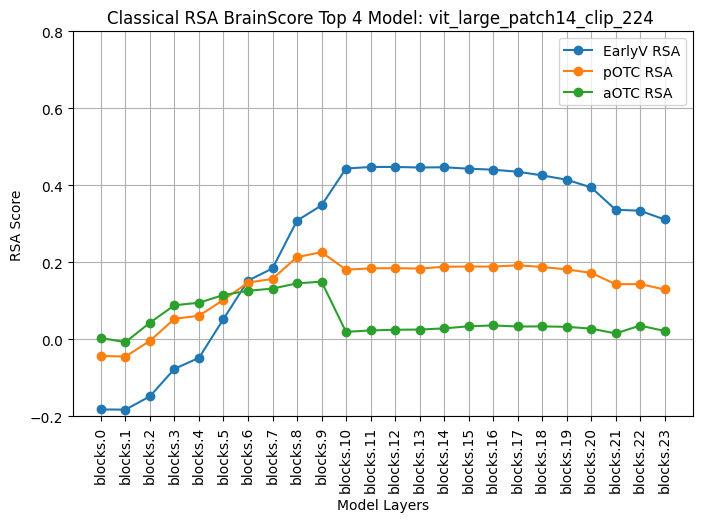

In [31]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_4_activations_blocks.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Top 4 Model: vit_large_patch14_clip_224 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


Loading top 5th avg model

In [35]:
# loading top 5th model
model = load_model("vit_large_patch14_clip_224:openai_ft_in1k")

Model vit_large_patch14_clip_224 loaded


In [36]:
model_5 = model.activations_model._model
model_5

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (

In [37]:
import timm 
timm.__version__
data_config = timm.data.resolve_model_data_config(model_5)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.48145466, 0.4578275, 0.40821073),
 'std': (0.26862954, 0.26130258, 0.27577711),
 'crop_pct': 1.0,
 'crop_mode': 'center'}

In [38]:
# this has 224 img size but different normalization!
'''Note: I am using different normalization for img 224'''

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from neuroai_kit.datasets import StreamingDataset

def load_datas(dataset, batch_size=None, image_size=224, fill_color=(255, 255, 255)):
    # Mapping of normalization parameters for different image sizes
    norm_params = {
        224: {
            'mean': (0.48145466, 0.4578275, 0.40821073),
            'std': (0.26862954, 0.26130258, 0.27577711)
         },
        # 224: {
        #     'mean': (0.485, 0.456, 0.406),
        #     'std': (0.229, 0.224, 0.225)
        # }
        # Add more sizes if needed
    }

    # Use the specified image_size or default to 384 if not found in mapping
    params = norm_params.get(image_size, norm_params[224])
    
    def data_transformations(image_size):
        class EmbedInBackground:
            def __init__(self, output_size, fill_color=(0, 0, 0)):
                self.output_size = output_size
                self.fill_color = fill_color

            def __call__(self, img, position=None):
                img_width, img_height = img.size
                bg_width, bg_height = self.output_size
                background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
                if position is None:
                    x = (bg_width - img_width) // 2
                    y = (bg_height - img_height) // 2
                else:
                    x, y = position
                background.paste(img, (x, y))
                return background

        return transforms.Compose([
            # Embeds the image in a larger background (optional)
            EmbedInBackground((800, 800), fill_color=fill_color),
            # Resize to the required image_size
            transforms.Resize(image_size, interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=params['mean'], std=params['std'])
        ])
    
    transform = data_transformations(image_size)
    # Here you would normally apply the transform to your dataset.
    # For now, we return the transform for demonstration.
     # Create the dataset using your custom StreamingDataset (or any dataset class)
    dataset = StreamingDataset(dataset, transforms=transform)
    
    # Determine the batch size; if not provided, use the full dataset size
    batch_size = batch_size if batch_size else len(dataset)
    
    # Create a DataLoader to get the batch(es)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Retrieve the first batch (or iterate over the dataloader as needed)
    img_batch = next(iter(dataloader))
    
    # If the returned batch is a dict (with images under a specific key), adjust accordingly.
    if isinstance(img_batch, dict):
        img_batch = img_batch['image']  # adjust key if needed
    
    return img_batch
    

In [39]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_datas(dataset_path, image_size=224)

import neuroai_kit as nk

layers = [f"blocks.{i}" for i in range(24)] # 0- n-1, since there are 0-23 range is 24


model_4.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_4, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

blocks.0 torch.Size([72, 257, 1024])
blocks.1 torch.Size([72, 257, 1024])
blocks.2 torch.Size([72, 257, 1024])
blocks.3 torch.Size([72, 257, 1024])
blocks.4 torch.Size([72, 257, 1024])
blocks.5 torch.Size([72, 257, 1024])
blocks.6 torch.Size([72, 257, 1024])
blocks.7 torch.Size([72, 257, 1024])
blocks.8 torch.Size([72, 257, 1024])
blocks.9 torch.Size([72, 257, 1024])
blocks.10 torch.Size([72, 257, 1024])
blocks.11 torch.Size([72, 257, 1024])
blocks.12 torch.Size([72, 257, 1024])
blocks.13 torch.Size([72, 257, 1024])
blocks.14 torch.Size([72, 257, 1024])
blocks.15 torch.Size([72, 257, 1024])
blocks.16 torch.Size([72, 257, 1024])
blocks.17 torch.Size([72, 257, 1024])
blocks.18 torch.Size([72, 257, 1024])
blocks.19 torch.Size([72, 257, 1024])
blocks.20 torch.Size([72, 257, 1024])
blocks.21 torch.Size([72, 257, 1024])
blocks.22 torch.Size([72, 257, 1024])
blocks.23 torch.Size([72, 257, 1024])


In [40]:
torch.save(activations, 'model_5_activations_blocks.pt')

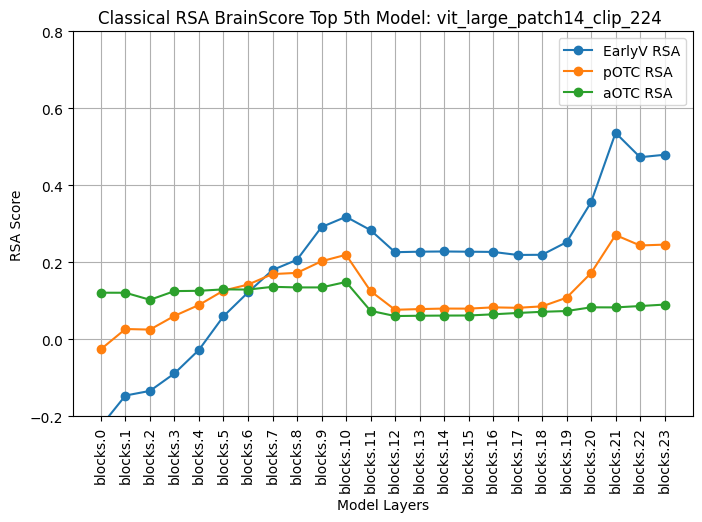

In [42]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_5_activations_blocks.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Top 5th Model: vit_large_patch14_clip_224 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


# Loading Top 5 Neural vision models (well 4, since model 1 is also a part of this group)

## Model 145: Alexnet_training_seed_01

In [43]:
## Model 145:
model = load_model("alexnet_training_seed_01")

brainscorevariability/models/model_weights/training_seed_01.pth: 100%|██████████| 201M/201M [00:00<00:00, 211MB/s]  


In [44]:
model_145 = model.activations_model._model
model_145

AlexNetV2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 4096, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(4096, 4096, kernel_size=

In [45]:
print_flattened_layers(model_145, prefix="")

features Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
features.0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
features.1 ReLU(inplace=True)
features.2 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
features.3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), p

In [52]:
model_145.__class__

brainscore_vision.models.alexnet_training_seed_01.model.alexnet_v2_pytorch.<locals>.AlexNetV2

In [58]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
features_layers = [f"features.{i}" for i in range(len(model_145.features))]
classifier_layers = [f"classifier.{i}" for i in range(len(model_145.classifier))]
layers = features_layers + classifier_layers


model_145.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_145, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 64, 54, 54])
features.1 torch.Size([72, 64, 54, 54])
features.2 torch.Size([72, 64, 26, 26])
features.3 torch.Size([72, 192, 26, 26])
features.4 torch.Size([72, 192, 26, 26])
features.5 torch.Size([72, 192, 12, 12])
features.6 torch.Size([72, 384, 12, 12])
features.7 torch.Size([72, 384, 12, 12])
features.8 torch.Size([72, 384, 12, 12])
features.9 torch.Size([72, 384, 12, 12])
features.10 torch.Size([72, 256, 12, 12])
features.11 torch.Size([72, 256, 12, 12])
features.12 torch.Size([72, 256, 5, 5])
classifier.0 torch.Size([72, 4096, 1, 1])
classifier.1 torch.Size([72, 4096, 1, 1])
classifier.2 torch.Size([72, 4096, 1, 1])
classifier.3 torch.Size([72, 4096, 1, 1])
classifier.4 torch.Size([72, 4096, 1, 1])
classifier.5 torch.Size([72, 4096, 1, 1])
classifier.6 torch.Size([72, 1000, 1, 1])


In [59]:
torch.save(activations,"model_145_features_classifiers_activations.pt")

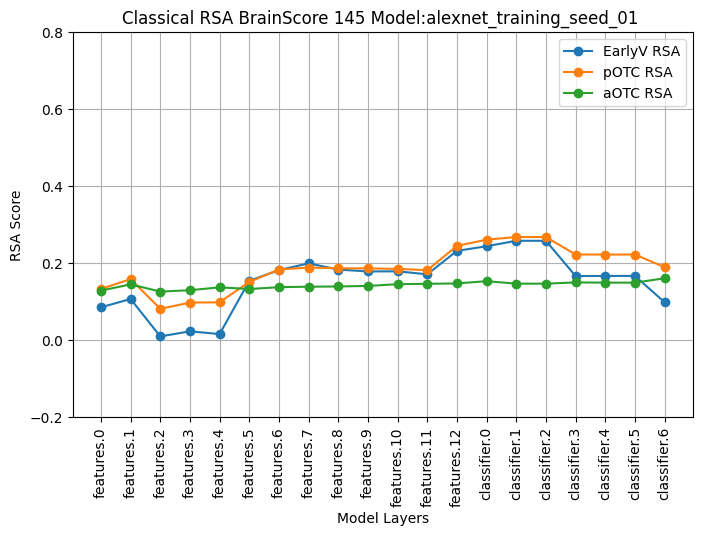

In [60]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_145_features_classifiers_activations.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore 145 Model:alexnet_training_seed_01 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 150: alexnet_training_seed_10

In [61]:
# model 150
model = load_model("alexnet_training_seed_10")

brainscorevariability/models/model_weights/training_seed_10.pth: 100%|██████████| 201M/201M [00:00<00:00, 215MB/s]  


In [63]:
model_150 = model.activations_model._model
model_150

AlexNetV2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 4096, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(4096, 4096, kernel_size=

In [64]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
features_layers = [f"features.{i}" for i in range(len(model_150.features))]
classifier_layers = [f"classifier.{i}" for i in range(len(model_150.classifier))]
layers = features_layers + classifier_layers


model_145.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_145, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 64, 54, 54])
features.1 torch.Size([72, 64, 54, 54])
features.2 torch.Size([72, 64, 26, 26])
features.3 torch.Size([72, 192, 26, 26])
features.4 torch.Size([72, 192, 26, 26])
features.5 torch.Size([72, 192, 12, 12])
features.6 torch.Size([72, 384, 12, 12])
features.7 torch.Size([72, 384, 12, 12])
features.8 torch.Size([72, 384, 12, 12])
features.9 torch.Size([72, 384, 12, 12])
features.10 torch.Size([72, 256, 12, 12])
features.11 torch.Size([72, 256, 12, 12])
features.12 torch.Size([72, 256, 5, 5])
classifier.0 torch.Size([72, 4096, 1, 1])
classifier.1 torch.Size([72, 4096, 1, 1])
classifier.2 torch.Size([72, 4096, 1, 1])
classifier.3 torch.Size([72, 4096, 1, 1])
classifier.4 torch.Size([72, 4096, 1, 1])
classifier.5 torch.Size([72, 4096, 1, 1])
classifier.6 torch.Size([72, 1000, 1, 1])


In [65]:
torch.save(activations, "model_150_features_classifiers_activations.pt")

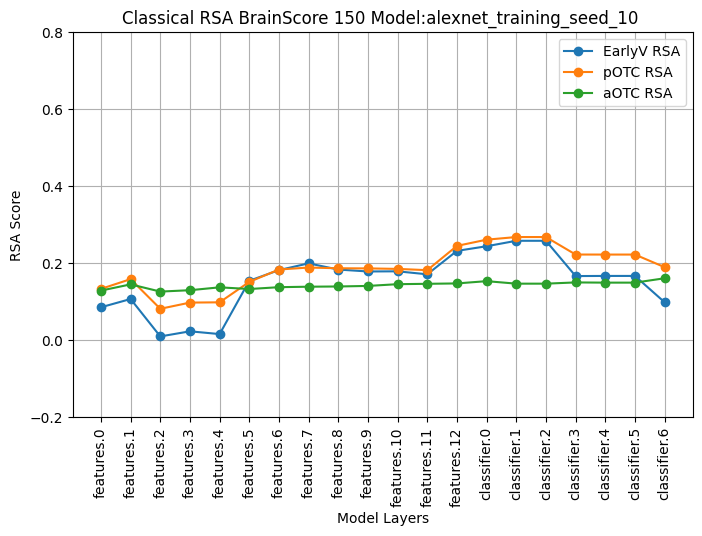

In [69]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_150_features_classifiers_activations.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore 150 Model:alexnet_training_seed_10 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 15: convnext_tiny_imagenet_full_seed-0

In [70]:
model = load_model('convnext_tiny_imagenet_full_seed-0')


Model loaded from https://epfl-neuroailab-scalinglaws.s3.eu-north-1.amazonaws.com/checkpoints/convnext_tiny_imagenet_full_seed-0/ep300.pt


In [72]:
model_15 = model.activations_model._model
# model.activations_model._model
model_15

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [73]:
model_15.__class__

torchvision.models.convnext.ConvNeXt

In [74]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
layers = [f"features.{i}" for i in range(len(model_15.features))]



model_15.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_15, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 96, 56, 56])
features.1 torch.Size([72, 96, 56, 56])
features.2 torch.Size([72, 192, 28, 28])
features.3 torch.Size([72, 192, 28, 28])
features.4 torch.Size([72, 384, 14, 14])
features.5 torch.Size([72, 384, 14, 14])
features.6 torch.Size([72, 768, 7, 7])
features.7 torch.Size([72, 768, 7, 7])


In [75]:
torch.save(activations, "model_15_activation_features.pt")

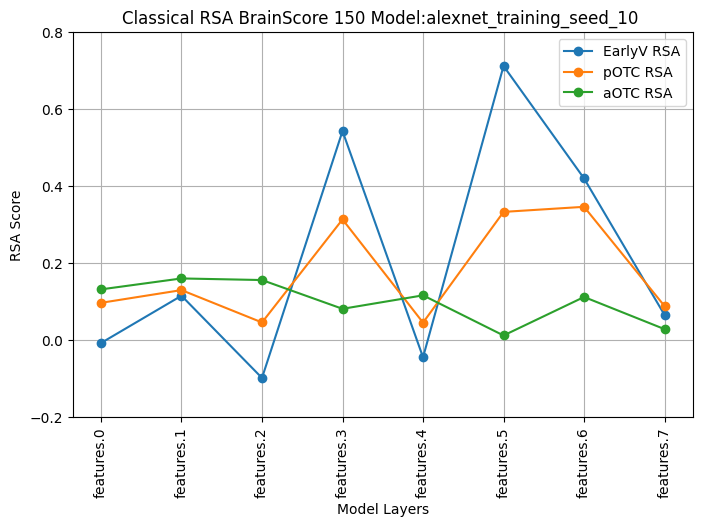

In [76]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_15_activation_features.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore 15 Model:convnext_tiny_imagenet_full_seed-0 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 7: vit_relpos_base_patch16_clsgap_224:sw_in1k

In [2]:
model = load_model("vit_relpos_base_patch16_clsgap_224:sw_in1k")

Model vit_relpos_base_patch16_clsgap_224 loaded


In [3]:
model_7 = model.activations_model._model
model_7

VisionTransformerRelPos(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x RelPosBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): RelPosAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (q_norm): Identity()
        (k_norm): Identity()
        (rel_pos): RelPosMlp(
          (bias_act): Identity()
          (mlp): Mlp(
            (fc1): Linear(in_features=2, out_features=128, bias=True)
            (act): ReLU()
            (drop1): Dropout(p=0.125, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=128, out_features=12, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
        )
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplac

In [4]:
model_7.__class__
import timm 
timm.__version__
data_config = timm.data.resolve_model_data_config(model_7)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [7]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data2(dataset_path, image_size=224)

import neuroai_kit as nk

layers = [f"blocks.{i}" for i in range(12)]
# 0- n-1, since there are 0-23 range is 24


model_7.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_7, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

blocks.0 torch.Size([72, 197, 768])
blocks.1 torch.Size([72, 197, 768])
blocks.2 torch.Size([72, 197, 768])
blocks.3 torch.Size([72, 197, 768])
blocks.4 torch.Size([72, 197, 768])
blocks.5 torch.Size([72, 197, 768])
blocks.6 torch.Size([72, 197, 768])
blocks.7 torch.Size([72, 197, 768])
blocks.8 torch.Size([72, 197, 768])
blocks.9 torch.Size([72, 197, 768])
blocks.10 torch.Size([72, 197, 768])
blocks.11 torch.Size([72, 197, 768])


In [10]:
torch.save(activations, "Model_7_activations_block.pt")

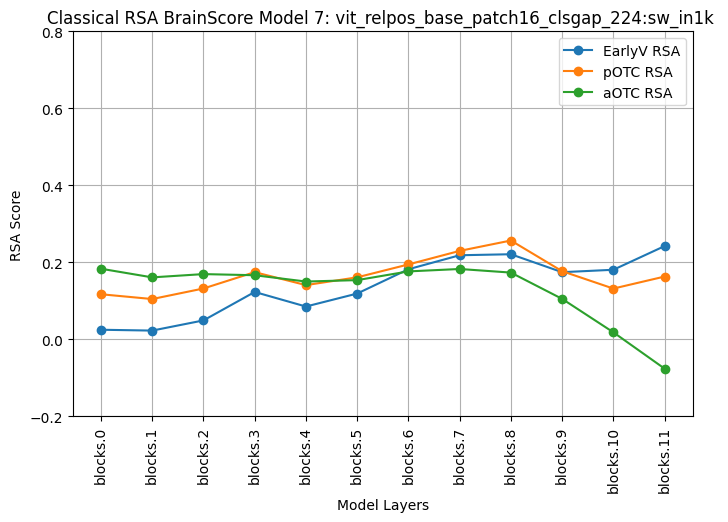

In [12]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('Model_7_activations_block.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 7: vit_relpos_base_patch16_clsgap_224:sw_in1k ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


# Top V1 Models

## Model 151: alexnet_training_seed_07

In [13]:
model = load_model("alexnet_training_seed_07")

brainscorevariability/models/model_weights/training_seed_07.pth: 100%|██████████| 201M/201M [00:01<00:00, 189MB/s]  


In [14]:
model_151 = model.activations_model._model
model_151

AlexNetV2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 4096, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(4096, 4096, kernel_size=

In [17]:
print_flattened_layers(model_151, prefix="")

features Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
features.0 Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
features.1 ReLU(inplace=True)
features.2 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
features.3 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), p

In [19]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
features_layers = [f"features.{i}" for i in range(len(model_151.features))]
classifier_layers = [f"classifier.{i}" for i in range(len(model_151.classifier))]
layers = features_layers + classifier_layers


model_151.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_151, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 64, 54, 54])
features.1 torch.Size([72, 64, 54, 54])
features.2 torch.Size([72, 64, 26, 26])
features.3 torch.Size([72, 192, 26, 26])
features.4 torch.Size([72, 192, 26, 26])
features.5 torch.Size([72, 192, 12, 12])
features.6 torch.Size([72, 384, 12, 12])
features.7 torch.Size([72, 384, 12, 12])
features.8 torch.Size([72, 384, 12, 12])
features.9 torch.Size([72, 384, 12, 12])
features.10 torch.Size([72, 256, 12, 12])
features.11 torch.Size([72, 256, 12, 12])
features.12 torch.Size([72, 256, 5, 5])
classifier.0 torch.Size([72, 4096, 1, 1])
classifier.1 torch.Size([72, 4096, 1, 1])
classifier.2 torch.Size([72, 4096, 1, 1])
classifier.3 torch.Size([72, 4096, 1, 1])
classifier.4 torch.Size([72, 4096, 1, 1])
classifier.5 torch.Size([72, 4096, 1, 1])
classifier.6 torch.Size([72, 1000, 1, 1])


In [20]:
torch.save(activations, "model_151_features_classifiers_activations.pt")

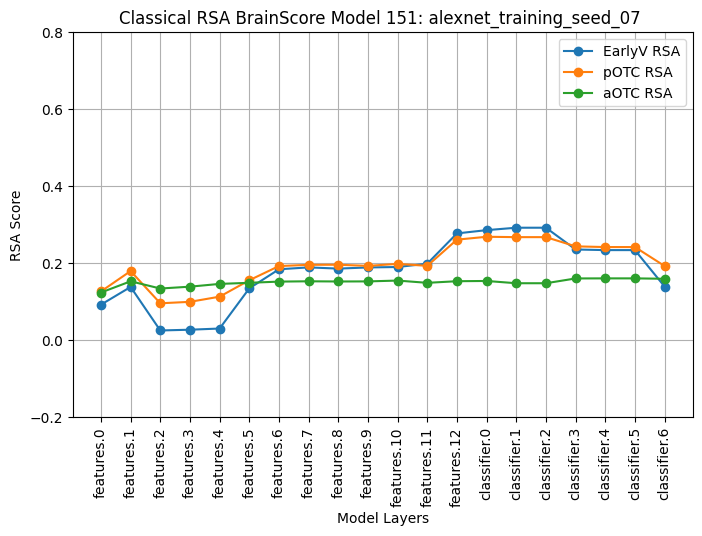

In [22]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_151_features_classifiers_activations.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 151: alexnet_training_seed_07 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 163: alexnet_training_seed_09"

In [23]:
model = load_model("alexnet_training_seed_09")

brainscorevariability/models/model_weights/training_seed_09.pth: 100%|██████████| 201M/201M [00:01<00:00, 138MB/s]  


In [24]:
model_163 = model.activations_model._model
model_163

AlexNetV2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 4096, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(4096, 4096, kernel_size=

In [25]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
features_layers = [f"features.{i}" for i in range(len(model_163.features))]
classifier_layers = [f"classifier.{i}" for i in range(len(model_163.classifier))]
layers = features_layers + classifier_layers


model_163.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_163, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 64, 54, 54])
features.1 torch.Size([72, 64, 54, 54])
features.2 torch.Size([72, 64, 26, 26])
features.3 torch.Size([72, 192, 26, 26])
features.4 torch.Size([72, 192, 26, 26])
features.5 torch.Size([72, 192, 12, 12])
features.6 torch.Size([72, 384, 12, 12])
features.7 torch.Size([72, 384, 12, 12])
features.8 torch.Size([72, 384, 12, 12])
features.9 torch.Size([72, 384, 12, 12])
features.10 torch.Size([72, 256, 12, 12])
features.11 torch.Size([72, 256, 12, 12])
features.12 torch.Size([72, 256, 5, 5])
classifier.0 torch.Size([72, 4096, 1, 1])
classifier.1 torch.Size([72, 4096, 1, 1])
classifier.2 torch.Size([72, 4096, 1, 1])
classifier.3 torch.Size([72, 4096, 1, 1])
classifier.4 torch.Size([72, 4096, 1, 1])
classifier.5 torch.Size([72, 4096, 1, 1])
classifier.6 torch.Size([72, 1000, 1, 1])


In [26]:
torch.save(activations, "model_163_features_classifiers_activations.pt")

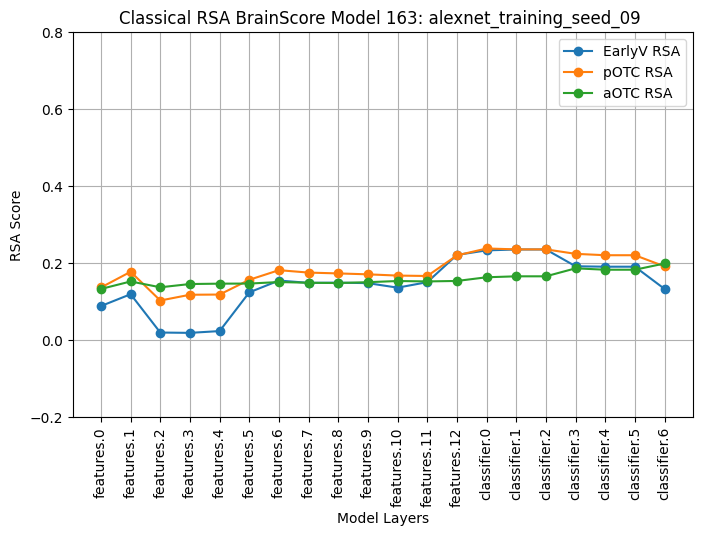

In [28]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_163_features_classifiers_activations.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 163: alexnet_training_seed_09 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 166: alexnet_training_seed_02

In [4]:
model = load_model("alexnet_training_seed_02")

brainscorevariability/models/model_weights/training_seed_02.pth: 100%|██████████| 201M/201M [00:01<00:00, 170MB/s] 


In [5]:
model_166 = model.activations_model._model
model_166

AlexNetV2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 4096, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(4096, 4096, kernel_size=

In [6]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
features_layers = [f"features.{i}" for i in range(len(model_166.features))]
classifier_layers = [f"classifier.{i}" for i in range(len(model_166.classifier))]
layers = features_layers + classifier_layers


model_166.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_166, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 64, 54, 54])
features.1 torch.Size([72, 64, 54, 54])
features.2 torch.Size([72, 64, 26, 26])
features.3 torch.Size([72, 192, 26, 26])
features.4 torch.Size([72, 192, 26, 26])
features.5 torch.Size([72, 192, 12, 12])
features.6 torch.Size([72, 384, 12, 12])
features.7 torch.Size([72, 384, 12, 12])
features.8 torch.Size([72, 384, 12, 12])
features.9 torch.Size([72, 384, 12, 12])
features.10 torch.Size([72, 256, 12, 12])
features.11 torch.Size([72, 256, 12, 12])
features.12 torch.Size([72, 256, 5, 5])
classifier.0 torch.Size([72, 4096, 1, 1])
classifier.1 torch.Size([72, 4096, 1, 1])
classifier.2 torch.Size([72, 4096, 1, 1])
classifier.3 torch.Size([72, 4096, 1, 1])
classifier.4 torch.Size([72, 4096, 1, 1])
classifier.5 torch.Size([72, 4096, 1, 1])
classifier.6 torch.Size([72, 1000, 1, 1])


In [7]:
torch.save(activations, "model_166_features_classifiers.pt")

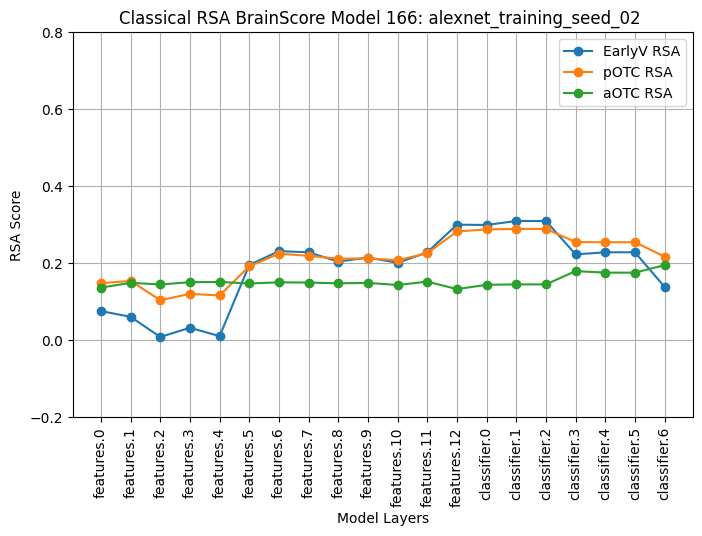

In [9]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_166_features_classifiers.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 166: alexnet_training_seed_02 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


# Top V2 Models: 170, 157

## Model 170: alexnet_training_seed_03

In [10]:
model = load_model("alexnet_training_seed_03")

brainscorevariability/models/model_weights/training_seed_03.pth: 100%|██████████| 201M/201M [00:01<00:00, 165MB/s] 


In [14]:
model_170 = model.activations_model._model
model_170


AlexNetV2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 4096, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(4096, 4096, kernel_size=

In [15]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
features_layers = [f"features.{i}" for i in range(len(model_170.features))]
classifier_layers = [f"classifier.{i}" for i in range(len(model_170.classifier))]
layers = features_layers + classifier_layers


model_170.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_170, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 64, 54, 54])
features.1 torch.Size([72, 64, 54, 54])
features.2 torch.Size([72, 64, 26, 26])
features.3 torch.Size([72, 192, 26, 26])
features.4 torch.Size([72, 192, 26, 26])
features.5 torch.Size([72, 192, 12, 12])
features.6 torch.Size([72, 384, 12, 12])
features.7 torch.Size([72, 384, 12, 12])
features.8 torch.Size([72, 384, 12, 12])
features.9 torch.Size([72, 384, 12, 12])
features.10 torch.Size([72, 256, 12, 12])
features.11 torch.Size([72, 256, 12, 12])
features.12 torch.Size([72, 256, 5, 5])
classifier.0 torch.Size([72, 4096, 1, 1])
classifier.1 torch.Size([72, 4096, 1, 1])
classifier.2 torch.Size([72, 4096, 1, 1])
classifier.3 torch.Size([72, 4096, 1, 1])
classifier.4 torch.Size([72, 4096, 1, 1])
classifier.5 torch.Size([72, 4096, 1, 1])
classifier.6 torch.Size([72, 1000, 1, 1])


In [16]:
torch.save(activations, "model_170_features_classifiers_activations.pt")

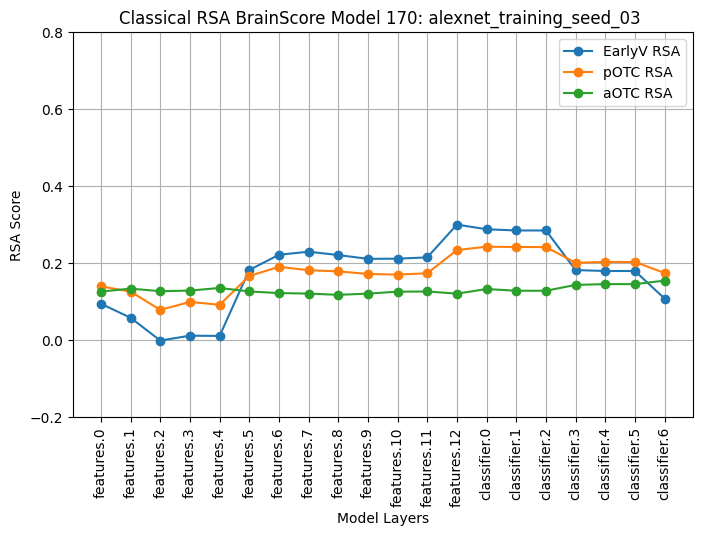

In [19]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_170_features_classifiers_activations.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    #stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    #Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 170: alexnet_training_seed_03 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 157: alexnet_training_seed_06

In [20]:
model = load_model("alexnet_training_seed_06")

brainscorevariability/models/model_weights/training_seed_06.pth: 100%|██████████| 201M/201M [00:01<00:00, 201MB/s] 


In [22]:
model_157 = model.activations_model._model
model_157

AlexNetV2(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 4096, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(4096, 4096, kernel_size=

In [23]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
features_layers = [f"features.{i}" for i in range(len(model_157.features))]
classifier_layers = [f"classifier.{i}" for i in range(len(model_157.classifier))]
layers = features_layers + classifier_layers


model_157.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_157, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 64, 54, 54])
features.1 torch.Size([72, 64, 54, 54])
features.2 torch.Size([72, 64, 26, 26])
features.3 torch.Size([72, 192, 26, 26])
features.4 torch.Size([72, 192, 26, 26])
features.5 torch.Size([72, 192, 12, 12])
features.6 torch.Size([72, 384, 12, 12])
features.7 torch.Size([72, 384, 12, 12])
features.8 torch.Size([72, 384, 12, 12])
features.9 torch.Size([72, 384, 12, 12])
features.10 torch.Size([72, 256, 12, 12])
features.11 torch.Size([72, 256, 12, 12])
features.12 torch.Size([72, 256, 5, 5])
classifier.0 torch.Size([72, 4096, 1, 1])
classifier.1 torch.Size([72, 4096, 1, 1])
classifier.2 torch.Size([72, 4096, 1, 1])
classifier.3 torch.Size([72, 4096, 1, 1])
classifier.4 torch.Size([72, 4096, 1, 1])
classifier.5 torch.Size([72, 4096, 1, 1])
classifier.6 torch.Size([72, 1000, 1, 1])


In [24]:
torch.save(activations, "model_157_features_classifiers_activations.pt")

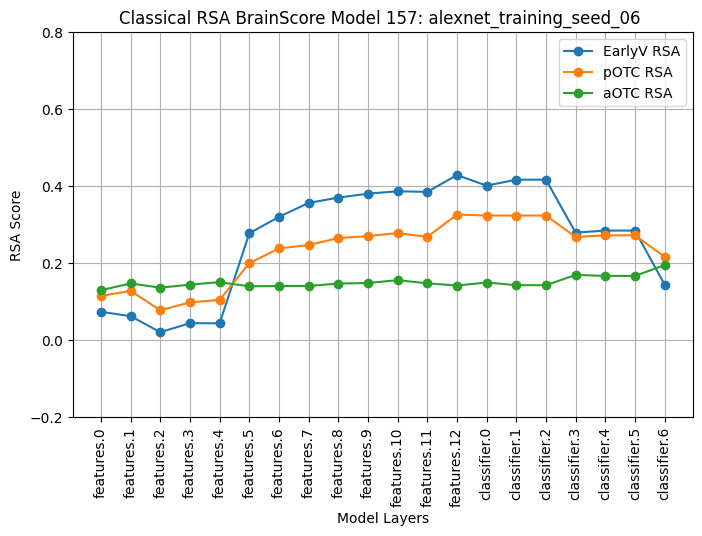

In [25]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_157_features_classifiers_activations.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    #stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    #Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 157: alexnet_training_seed_06 ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


# Top V4 Models: 69, 39, 11, 143

## Model 69: efficientnet_b2_imagenet_full

In [26]:
model = load_model("efficientnet_b2_imagenet_full")

Downloading: "https://epfl-neuroailab-scalinglaws.s3.eu-north-1.amazonaws.com/checkpoints/efficientnet_b2_imagenet_full/ep100.pt" to /home/zeus/.cache/torch/hub/checkpoints/efficientnet_b2_imagenet_full_ep100.pt
100%|██████████| 35.2M/35.2M [00:02<00:00, 14.6MB/s]


Model loaded from https://epfl-neuroailab-scalinglaws.s3.eu-north-1.amazonaws.com/checkpoints/efficientnet_b2_imagenet_full/ep100.pt


In [28]:
model_69 = model.activations_model._model
model_69

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [29]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
layers = [f"features.{i}" for i in range(len(model_69.features))]



model_69.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_69, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

features.0 torch.Size([72, 32, 112, 112])
features.1 torch.Size([72, 16, 112, 112])
features.2 torch.Size([72, 24, 56, 56])
features.3 torch.Size([72, 48, 28, 28])
features.4 torch.Size([72, 88, 14, 14])
features.5 torch.Size([72, 120, 14, 14])
features.6 torch.Size([72, 208, 7, 7])
features.7 torch.Size([72, 352, 7, 7])
features.8 torch.Size([72, 1408, 7, 7])


In [30]:
torch.save(activations, "model_69_activation_features.pt")

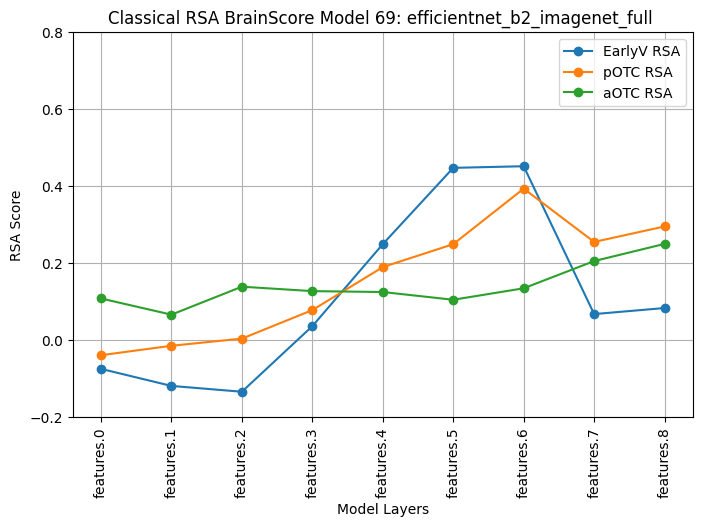

In [31]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_69_activation_features.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    #stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    #Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 69: efficientnet_b2_imagenet_full ")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 39: cvt_cvt-21-384-in1k_4_LucyV4

In [32]:
model = load_model("cvt_cvt-21-384-in1k_4_LucyV4")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.1 MB/s eta 0:00:00a 0:00:01


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

In [35]:
model_39 = model.activations_model._model
model_39


CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [36]:
''' Img size is 384 with normalization of 224'''

def loading_data(dataset, batch_size=None, image_size=384, fill_color=(255, 255, 255)):
    # Mapping of normalization parameters for different image sizes
    norm_params = {
        # 384: {
        #     'mean': (0.48145466, 0.4578275, 0.40821073),
        #     'std': (0.26862954, 0.26130258, 0.27577711)
        # },
        384: {
            'mean': (0.485, 0.456, 0.406),
            'std': (0.229, 0.224, 0.225)
        }
        # Add more sizes if needed
    }
    
    # Get parameters based on image_size; default to 384 if not found
    params = norm_params.get(image_size, norm_params[384])
    
    # Define the transformation pipeline with the desired image size and normalization.
    def data_transformations(image_size):
        class EmbedInBackground:
            def __init__(self, output_size, fill_color=(0, 0, 0)):
                self.output_size = output_size
                self.fill_color = fill_color

            def __call__(self, img, position=None):
                img_width, img_height = img.size
                bg_width, bg_height = self.output_size
                background = Image.new('RGB', (bg_width, bg_height), self.fill_color)
                if position is None:
                    x = (bg_width - img_width) // 2
                    y = (bg_height - img_height) // 2
                else:
                    x, y = position
                background.paste(img, (x, y))
                return background

        return transforms.Compose([
            # Optionally embed the image in a larger background
            EmbedInBackground((800, 800), fill_color=fill_color),
            # Resize to the required image_size using bicubic interpolation
            transforms.Resize(image_size, interpolation=Image.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=params['mean'], std=params['std'])
        ])
    
    # Build the transformation using the provided image_size
    transform = data_transformations(image_size)
    
    # Create the dataset using your custom StreamingDataset (or any dataset class)
    dataset = StreamingDataset(dataset, transforms=transform)
    
    # Determine the batch size; if not provided, use the full dataset size
    batch_size = batch_size if batch_size else len(dataset)
    
    # Create a DataLoader to get the batch(es)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    # Retrieve the first batch (or iterate over the dataloader as needed)
    img_batch = next(iter(dataloader))
    
    # If the returned batch is a dict (with images under a specific key), adjust accordingly.
    if isinstance(img_batch, dict):
        img_batch = img_batch['image']  # adjust key if needed
    
    return img_batch

In [38]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=384)

import neuroai_kit as nk

layers = []
for stage_idx, stage in enumerate(model_39.cvt.encoder.stages):
    for layer_idx, _ in enumerate(stage.layers):
        layers.append(f"cvt.encoder.stages.{stage_idx}.layers.{layer_idx}")



model_39.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_39, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

cvt.encoder.stages.0.layers.0 torch.Size([72, 9216, 64])
cvt.encoder.stages.1.layers.0 torch.Size([72, 2304, 192])
cvt.encoder.stages.1.layers.1 torch.Size([72, 2304, 192])
cvt.encoder.stages.1.layers.2 torch.Size([72, 2304, 192])
cvt.encoder.stages.1.layers.3 torch.Size([72, 2304, 192])
cvt.encoder.stages.2.layers.0 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.1 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.2 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.3 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.4 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.5 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.6 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.7 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.8 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.9 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.10 torch.Size([72, 577, 384])
cvt.encoder.stages.2.layers.11 torch.Size([72, 577, 384])
cvt.encoder.stages.2.laye

In [39]:
torch.save(activations, "model_39_activations_cvt_stages.pt")

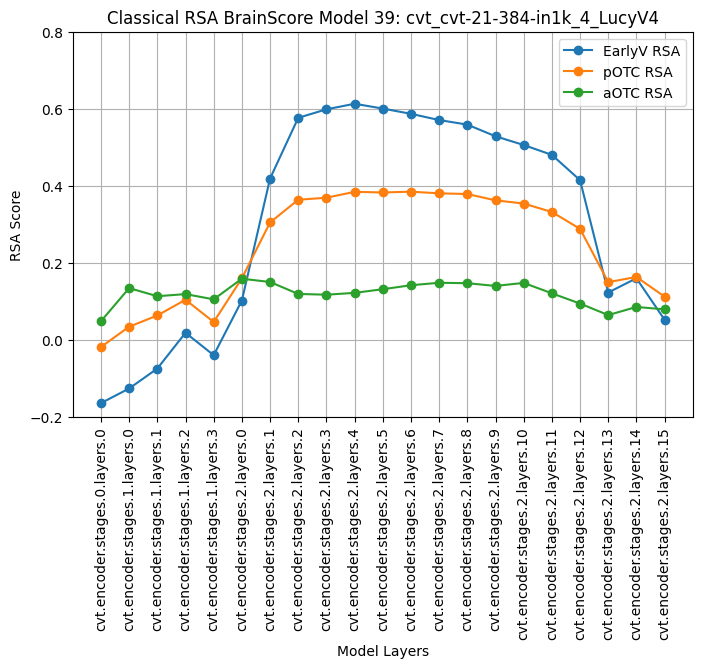

In [40]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_39_activations_cvt_stages.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    #stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    #Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 39: cvt_cvt-21-384-in1k_4_LucyV4")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 143: omnivore_swinS
''' Note this model requires a video input '''

In [41]:
model = load_model("omnivore_swinS")

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 172.8 MB/s eta 0:00:0000:01
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144591 sha256=33983ad19491e090830a2936f251d40c06fbba006643d37f6c5739fc47c39f36
  Stored in directory: /home/zeus/.cache/pip/wheels/1a/97/32/461f837398029ad76911109f07047fde1d7b661a147c7c56d1
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31570 sha256=4a4561ea4af8e610685f797d63fd4785da621cba5b57ecf31af9eaecfd91b527
  Stored in directory: /home/zeus/.cache/pip/wheels/ba/5e/16/

Downloading: "https://github.com/facebookresearch/omnivore/zipball/main" to /home/zeus/.cache/torch/hub/main.zip
/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://dl.fbaipublicfiles.com/omnivore/models/swinS_checkpoint.torch" to /home/zeus/.cache/torch/hub/checkpoints/swinS_checkpoint.torch
100%|██████████| 221M/221M [00:06<00:00, 33.8MB/s] 


In [42]:
model_143 = model.activations_model._model
model_143

OmnivoreModel(
  (trunk): SwinTransformer3D(
    (im2vid): Im2Video()
    (patch_embed): PatchEmbed3D(
      (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (depth_patch_embed): PatchEmbed3D(
      (proj): Conv3d(1, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock3D(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention3D(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=

In [48]:
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)
imgs = imgs.unsqueeze(2)  # Add the dummy time dimension

import neuroai_kit as nk

layers = [f"trunk.layers.{i}" for i in range(len(model_143.trunk.layers))]

model_143.eval()
with torch.no_grad():
    with nk.NeuroElectrodeArray(model_143, layers) as electrode:
        activations = electrode(imgs)

# If activations is a dictionary, you can iterate over it:
if isinstance(activations, dict):
    for layer_name, act in activations.items():
        print(layer_name, act.shape)
else:
    print("Final output shape:", activations.shape)


Final output shape: torch.Size([72, 1000])


In [49]:
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)
# Add dummy time dimension to match [B, C, T, H, W] input expectation.
imgs = imgs.unsqueeze(2)

import neuroai_kit as nk

# Build list of keys for each block.
layers = []
for stage_idx, stage in enumerate(model_143.trunk.layers):
    if hasattr(stage, "blocks"):
        for block_idx, _ in enumerate(stage.blocks):
            layers.append(f"trunk.layers.{stage_idx}.blocks.{block_idx}")

layers = []
for stage_idx, stage in enumerate(model_143.trunk.layers):
    # Check that the stage has a 'blocks' attribute.
    if hasattr(stage, "blocks"):
        for block_idx in range(len(stage.blocks)):
            layers.append(f"trunk.layers.{stage_idx}.blocks.{block_idx}")


# Optionally, you can print the available named modules to verify the keys:
# print(dict(model_143.named_modules()).keys())

model_143.eval()
with torch.no_grad():
    with nk.NeuroElectrodeArray(model_143, layers) as electrode:
        activations = electrode(imgs)

# activations should now be a dict mapping each layer key to its output tensor.
for layer_name, act in activations.items():
    print(layer_name, act.shape)


AttributeError: 'Tensor' object has no attribute 'items'

In [50]:
modules = dict(model_143.named_modules())
print(modules.keys())


dict_keys(['', 'trunk', 'trunk.im2vid', 'trunk.patch_embed', 'trunk.patch_embed.proj', 'trunk.patch_embed.norm', 'trunk.depth_patch_embed', 'trunk.depth_patch_embed.proj', 'trunk.depth_patch_embed.norm', 'trunk.pos_drop', 'trunk.layers', 'trunk.layers.0', 'trunk.layers.0.blocks', 'trunk.layers.0.blocks.0', 'trunk.layers.0.blocks.0.norm1', 'trunk.layers.0.blocks.0.attn', 'trunk.layers.0.blocks.0.attn.qkv', 'trunk.layers.0.blocks.0.attn.attn_drop', 'trunk.layers.0.blocks.0.attn.proj', 'trunk.layers.0.blocks.0.attn.proj_drop', 'trunk.layers.0.blocks.0.attn.softmax', 'trunk.layers.0.blocks.0.drop_path', 'trunk.layers.0.blocks.0.norm2', 'trunk.layers.0.blocks.0.mlp', 'trunk.layers.0.blocks.0.mlp.fc1', 'trunk.layers.0.blocks.0.mlp.act', 'trunk.layers.0.blocks.0.mlp.fc2', 'trunk.layers.0.blocks.0.mlp.drop', 'trunk.layers.0.blocks.1', 'trunk.layers.0.blocks.1.norm1', 'trunk.layers.0.blocks.1.attn', 'trunk.layers.0.blocks.1.attn.qkv', 'trunk.layers.0.blocks.1.attn.attn_drop', 'trunk.layers.0.bl

In [ ]:
torch.save(activations, "model_143_activations_trunk_layers")

## Model 11: swin_small_patch4_window7_224:ms_in22k_ft_in1k

In [51]:
model = load_model("swin_small_patch4_window7_224:ms_in22k_ft_in1k")

model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

Model swin_small_patch4_window7_224 loaded


In [52]:
model_11 = model.activations_model._model
model_11

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [59]:
modules = dict(model_11.named_modules())
print(modules.keys())


dict_keys(['', 'patch_embed', 'patch_embed.proj', 'patch_embed.norm', 'layers', 'layers.0', 'layers.0.downsample', 'layers.0.blocks', 'layers.0.blocks.0', 'layers.0.blocks.0.norm1', 'layers.0.blocks.0.attn', 'layers.0.blocks.0.attn.qkv', 'layers.0.blocks.0.attn.attn_drop', 'layers.0.blocks.0.attn.proj', 'layers.0.blocks.0.attn.proj_drop', 'layers.0.blocks.0.attn.softmax', 'layers.0.blocks.0.drop_path1', 'layers.0.blocks.0.norm2', 'layers.0.blocks.0.mlp', 'layers.0.blocks.0.mlp.fc1', 'layers.0.blocks.0.mlp.act', 'layers.0.blocks.0.mlp.drop1', 'layers.0.blocks.0.mlp.norm', 'layers.0.blocks.0.mlp.fc2', 'layers.0.blocks.0.mlp.drop2', 'layers.0.blocks.0.drop_path2', 'layers.0.blocks.1', 'layers.0.blocks.1.norm1', 'layers.0.blocks.1.attn', 'layers.0.blocks.1.attn.qkv', 'layers.0.blocks.1.attn.attn_drop', 'layers.0.blocks.1.attn.proj', 'layers.0.blocks.1.attn.proj_drop', 'layers.0.blocks.1.attn.softmax', 'layers.0.blocks.1.drop_path1', 'layers.0.blocks.1.norm2', 'layers.0.blocks.1.mlp', 'laye

In [60]:
# Load images: they are 4D [B, C, H, W]
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

# Construct layer keys using the actual module names.
layers = []
for stage_idx, stage in enumerate(model_11.layers):
    if hasattr(stage, "blocks"):
        for block_idx in range(len(stage.blocks)):
            layers.append(f"layers.{stage_idx}.blocks.{block_idx}")

print("Layer keys:", layers)

model_11.eval()
with torch.no_grad():
    with nk.NeuroElectrodeArray(model_11, layers) as electrode:
        activations = electrode(imgs)

if isinstance(activations, dict):
    for layer_name, act in activations.items():
        print(layer_name, act.shape)
else:
    print("Returned activations is a tensor with shape:", activations.shape)


Layer keys: ['layers.0.blocks.0', 'layers.0.blocks.1', 'layers.1.blocks.0', 'layers.1.blocks.1', 'layers.2.blocks.0', 'layers.2.blocks.1', 'layers.2.blocks.2', 'layers.2.blocks.3', 'layers.2.blocks.4', 'layers.2.blocks.5', 'layers.2.blocks.6', 'layers.2.blocks.7', 'layers.2.blocks.8', 'layers.2.blocks.9', 'layers.2.blocks.10', 'layers.2.blocks.11', 'layers.2.blocks.12', 'layers.2.blocks.13', 'layers.2.blocks.14', 'layers.2.blocks.15', 'layers.2.blocks.16', 'layers.2.blocks.17', 'layers.3.blocks.0', 'layers.3.blocks.1']


RecursionError: maximum recursion depth exceeded while calling a Python object

# loading models 11 and 143

In [17]:
model = load_model("swin_small_patch4_window7_224:ms_in22k_ft_in1k")

Model swin_small_patch4_window7_224 loaded


In [18]:
model_11 = model.activations_model._model
model_11

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [19]:
print_flattened_layers(model_11, prefix="")

patch_embed PatchEmbed(
  (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
)
patch_embed.proj Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
patch_embed.norm LayerNorm((96,), eps=1e-05, elementwise_affine=True)
layers Sequential(
  (0): SwinTransformerStage(
    (downsample): Identity()
    (blocks): Sequential(
      (0): SwinTransformerBlock(
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (attn): WindowAttention(
          (qkv): Linear(in_features=96, out_features=288, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=96, out_features=96, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (softmax): Softmax(dim=-1)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=96, out_features=384, bias=

In [29]:
from neuroai_kit import get_layers
get_layers(model_11, parent_name='')

['patch_embed.proj',
 'patch_embed.norm',
 'layers.0.downsample',
 'layers.0.blocks.0.norm1',
 'layers.0.blocks.0.attn.qkv',
 'layers.0.blocks.0.attn.attn_drop',
 'layers.0.blocks.0.attn.proj',
 'layers.0.blocks.0.attn.proj_drop',
 'layers.0.blocks.0.attn.softmax',
 'layers.0.blocks.0.drop_path1',
 'layers.0.blocks.0.norm2',
 'layers.0.blocks.0.mlp.fc1',
 'layers.0.blocks.0.mlp.act',
 'layers.0.blocks.0.mlp.drop1',
 'layers.0.blocks.0.mlp.norm',
 'layers.0.blocks.0.mlp.fc2',
 'layers.0.blocks.0.mlp.drop2',
 'layers.0.blocks.0.drop_path2',
 'layers.0.blocks.1.norm1',
 'layers.0.blocks.1.attn.qkv',
 'layers.0.blocks.1.attn.attn_drop',
 'layers.0.blocks.1.attn.proj',
 'layers.0.blocks.1.attn.proj_drop',
 'layers.0.blocks.1.attn.softmax',
 'layers.0.blocks.1.drop_path1',
 'layers.0.blocks.1.norm2',
 'layers.0.blocks.1.mlp.fc1',
 'layers.0.blocks.1.mlp.act',
 'layers.0.blocks.1.mlp.drop1',
 'layers.0.blocks.1.mlp.norm',
 'layers.0.blocks.1.mlp.fc2',
 'layers.0.blocks.1.mlp.drop2',
 'layers.

In [24]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk


In [30]:
from neuroai_kit.electrode import get_layers
from pprint import pprint

def get_simplified_layers_swin_model(model):
    all_layers = get_layers(model)
    keep_layers = []
    for layer_name in all_layers:
        if 'blocks' in layer_name:
            parts = layer_name.split(".")[0:4]
            layer_name = ".".join(parts)
        if layer_name not in keep_layers:
            keep_layers.append(layer_name) 

    return keep_layers

layer_names = get_simplified_layers_swin_model(model.activations_model._model)
pprint(layer_names)  

['patch_embed.proj',
 'patch_embed.norm',
 'layers.0.downsample',
 'layers.0.blocks.0',
 'layers.0.blocks.1',
 'layers.1.downsample.norm',
 'layers.1.downsample.reduction',
 'layers.1.blocks.0',
 'layers.1.blocks.1',
 'layers.2.downsample.norm',
 'layers.2.downsample.reduction',
 'layers.2.blocks.0',
 'layers.2.blocks.1',
 'layers.2.blocks.2',
 'layers.2.blocks.3',
 'layers.2.blocks.4',
 'layers.2.blocks.5',
 'layers.2.blocks.6',
 'layers.2.blocks.7',
 'layers.2.blocks.8',
 'layers.2.blocks.9',
 'layers.2.blocks.10',
 'layers.2.blocks.11',
 'layers.2.blocks.12',
 'layers.2.blocks.13',
 'layers.2.blocks.14',
 'layers.2.blocks.15',
 'layers.2.blocks.16',
 'layers.2.blocks.17',
 'layers.3.downsample.norm',
 'layers.3.downsample.reduction',
 'layers.3.blocks.0',
 'layers.3.blocks.1',
 'norm',
 'head.global_pool.pool',
 'head.global_pool.flatten',
 'head.drop',
 'head.fc',
 'head.flatten']


In [31]:
layers = get_simplified_layers_swin_model(model_11)
model_11.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_11, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

patch_embed.proj torch.Size([72, 96, 56, 56])
patch_embed.norm torch.Size([72, 56, 56, 96])
layers.0.downsample torch.Size([72, 56, 56, 96])
layers.0.blocks.0 torch.Size([72, 56, 56, 96])
layers.0.blocks.1 torch.Size([72, 56, 56, 96])
layers.1.downsample.norm torch.Size([72, 28, 28, 384])
layers.1.downsample.reduction torch.Size([72, 28, 28, 192])
layers.1.blocks.0 torch.Size([72, 28, 28, 192])
layers.1.blocks.1 torch.Size([72, 28, 28, 192])
layers.2.downsample.norm torch.Size([72, 14, 14, 768])
layers.2.downsample.reduction torch.Size([72, 14, 14, 384])
layers.2.blocks.0 torch.Size([72, 14, 14, 384])
layers.2.blocks.1 torch.Size([72, 14, 14, 384])
layers.2.blocks.2 torch.Size([72, 14, 14, 384])
layers.2.blocks.3 torch.Size([72, 14, 14, 384])
layers.2.blocks.4 torch.Size([72, 14, 14, 384])
layers.2.blocks.5 torch.Size([72, 14, 14, 384])
layers.2.blocks.6 torch.Size([72, 14, 14, 384])
layers.2.blocks.7 torch.Size([72, 14, 14, 384])
layers.2.blocks.8 torch.Size([72, 14, 14, 384])
layers.

In [32]:
torch.save(activations, "model_11_activations.pt")

In [ ]:
len(layer[i]for blocks)

In [33]:
model = load_model("omnivore_swinS")

Using cache found in /home/zeus/.cache/torch/hub/facebookresearch_omnivore_main


In [34]:
model_143 = model.activations_model._model
model_143

OmnivoreModel(
  (trunk): SwinTransformer3D(
    (im2vid): Im2Video()
    (patch_embed): PatchEmbed3D(
      (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (depth_patch_embed): PatchEmbed3D(
      (proj): Conv3d(1, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock3D(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention3D(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=

In [43]:
from neuroai_kit import get_layers
all_layers = get_layers(model_143, parent_name='')
all_layers

['trunk.im2vid',
 'trunk.patch_embed.proj',
 'trunk.patch_embed.norm',
 'trunk.depth_patch_embed.proj',
 'trunk.depth_patch_embed.norm',
 'trunk.pos_drop',
 'trunk.layers.0.blocks.0.norm1',
 'trunk.layers.0.blocks.0.attn.qkv',
 'trunk.layers.0.blocks.0.attn.attn_drop',
 'trunk.layers.0.blocks.0.attn.proj',
 'trunk.layers.0.blocks.0.attn.proj_drop',
 'trunk.layers.0.blocks.0.attn.softmax',
 'trunk.layers.0.blocks.0.drop_path',
 'trunk.layers.0.blocks.0.norm2',
 'trunk.layers.0.blocks.0.mlp.fc1',
 'trunk.layers.0.blocks.0.mlp.act',
 'trunk.layers.0.blocks.0.mlp.fc2',
 'trunk.layers.0.blocks.0.mlp.drop',
 'trunk.layers.0.blocks.1.norm1',
 'trunk.layers.0.blocks.1.attn.qkv',
 'trunk.layers.0.blocks.1.attn.attn_drop',
 'trunk.layers.0.blocks.1.attn.proj',
 'trunk.layers.0.blocks.1.attn.proj_drop',
 'trunk.layers.0.blocks.1.attn.softmax',
 'trunk.layers.0.blocks.1.drop_path',
 'trunk.layers.0.blocks.1.norm2',
 'trunk.layers.0.blocks.1.mlp.fc1',
 'trunk.layers.0.blocks.1.mlp.act',
 'trunk.lay

In [44]:
def get_trunk_blocks(model):
    block_names = []
    # Iterate over each trunk layer by index and module
    for i, trunk_layer in enumerate(model.trunk.layers):
        # Assuming that each trunk layer has an attribute 'blocks'
        # which is a list, tuple, or other iterable of blocks.
        # You may need to adjust this if your object type is different.
        for j in range(len(trunk_layer.blocks)):
            block_names.append(f"trunk.layers.{i}.blocks.{j}")
    return block_names

# Create the layer name list
layers = get_trunk_blocks(model_143)
print("Layers to probe:")
for l in layers:
    print(l)


Layers to probe:
trunk.layers.0.blocks.0
trunk.layers.0.blocks.1
trunk.layers.1.blocks.0
trunk.layers.1.blocks.1
trunk.layers.2.blocks.0
trunk.layers.2.blocks.1
trunk.layers.2.blocks.2
trunk.layers.2.blocks.3
trunk.layers.2.blocks.4
trunk.layers.2.blocks.5
trunk.layers.2.blocks.6
trunk.layers.2.blocks.7
trunk.layers.2.blocks.8
trunk.layers.2.blocks.9
trunk.layers.2.blocks.10
trunk.layers.2.blocks.11
trunk.layers.2.blocks.12
trunk.layers.2.blocks.13
trunk.layers.2.blocks.14
trunk.layers.2.blocks.15
trunk.layers.2.blocks.16
trunk.layers.2.blocks.17
trunk.layers.3.blocks.0
trunk.layers.3.blocks.1


In [57]:
imgs = load_data(dataset_path, image_size=224, add_extra_dimension=True)
print(imgs)
print(imgs.shape)


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    <function load_data.<locals>.<lambda> at 0x7f5cc6501c60>
)


AttributeError: 'Compose' object has no attribute 'shape'

In [59]:
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224, add_extra_dimension=True)

import neuroai_kit as nk
layers = get_trunk_blocks(model_143)

model_143.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_143, layers) as electrode:
        activations = electrode(imgs, input_type="image")
for layer_name, act in activations.items():
    print(layer_name, act.shape)

trunk.layers.0.blocks.0 torch.Size([72, 1, 56, 56, 96])
trunk.layers.0.blocks.1 torch.Size([72, 1, 56, 56, 96])
trunk.layers.1.blocks.0 torch.Size([72, 1, 28, 28, 192])
trunk.layers.1.blocks.1 torch.Size([72, 1, 28, 28, 192])
trunk.layers.2.blocks.0 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.1 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.2 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.3 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.4 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.5 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.6 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.7 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.8 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.9 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.10 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.11 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.12 torch.Size([72, 1, 14, 14, 384])
trunk.layers.2.blocks.13 torch

In [61]:
torch.save(activations, "model_143_activations.pt")

In [ ]:


# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24

layers = get_trunk_blocks(model_143)



model_143.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_143, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

KeyError: 'blocks.0'

# Top IT Models: 128, 134, 123, 115, 118

## Model 128: ReAlnet01_cornet

In [61]:
model = load_model("ReAlnet01_cornet")

  Cloning https://github.com/dicarlolab/CORnet.git to /tmp/pip-install-5sgzr45r/cornet_a3205add2fbc484fa0504db9445b44d4


  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet.git /tmp/pip-install-5sgzr45r/cornet_a3205add2fbc484fa0504db9445b44d4



  Resolved https://github.com/dicarlolab/CORnet.git to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for CORnet: filename=CORnet-0.1.0-py3-none-any.whl size=23276 sha256=e8ac867de29fb45aaf8e447b19aa71f83f307385f74987943042fc34560e9efb
  Stored in directory: /tmp/pip-ephem-wheel-cache-74vactlw/wheels/7d/71/5d/ff4f86828632f02f6bf3f16b6e5f5e1b166c4419547dd26517
Successfully built CORnet


In [71]:
print_flattened_layers(model_128, prefix="")

V1 Sequential(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin1): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin2): ReLU(inplace=True)
  (output): Identity()
)
V1.conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
V1.norm1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
V1.nonlin1 ReLU(inplace=True)
V1.pool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
V1.conv2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
V1.norm2 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [66]:
model_128.__class__

torch.nn.modules.container.Sequential

In [62]:
model_128 = model.activations_model._model
model_128

Sequential(
  (V1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin2): ReLU(inplace=True)
    (output): Identity()
  )
  (V2): CORblock_S(
    (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (nonlin1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, k

In [78]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
layers =["V1", "V2", "V4", "IT"]




model_128.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_128, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

AttributeError: 'Sequential' object has no attribute 'trunk'

In [72]:
def get_activations(model, layer_keys, x):
    activations = {}
    hooks = []
    modules = dict(model.named_modules())
    for key in layer_keys:
        if key in modules:
            def hook_fn(module, input, output, key=key):
                activations[key] = output
            hook = modules[key].register_forward_hook(hook_fn)
            hooks.append(hook)
        else:
            print(f"Warning: {key} not found in model.named_modules()")
    # Run the forward pass.
    _ = model(x)
    # Remove the hooks.
    for hook in hooks:
        hook.remove()
    return activations


In [73]:
imgs = load_data(dataset_path, image_size=224)
layer_keys = ["V1", "V2", "V4", "IT"]

activations = get_activations(model_128, layer_keys, imgs)
for key, act in activations.items():
    print(key, act.shape)


V1 torch.Size([72, 64, 56, 56])
V2 torch.Size([72, 128, 28, 28])
V4 torch.Size([72, 256, 14, 14])
IT torch.Size([72, 512, 7, 7])


In [74]:
torch.save(activations, "model_128_activations_regions.pt")

In [75]:
import pickle
import numpy as np
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_128_activations_regions.pt')


# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}


# Create a single figure
plt.figure(figsize=(8, 5))

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    #stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

    # Create an array of RSA values for these layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    
    # If the stop_layer is present, find its index and truncate the list
    if stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]    

# Now plot only the truncated list of layers
    correlation_values = np.array([rsa_values[layer] for layer in layers])
    # If the result is 2D (multiple values per layer), extract only the first column
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    #Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 128: ReAlnet01_cornet")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [79]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_128_activations_regions.pt')

# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI using your RSA function.
# (Assuming compute_classical_rsa_from_activations is already defined.)
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Create a single figure for plotting
plt.figure(figsize=(8, 5))

# Optional: Define stop_layer if you want to truncate at a particular layer.
# stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # If you want to truncate at a stop_layer, do so:
    if 'stop_layer' in locals() and stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]

    # Create an array of RSA values for these layers,
    # detaching each tensor and moving it to CPU before converting to numpy.
    correlation_values = np.array([rsa_values[layer].detach().cpu().numpy() for layer in layers])
    
    # If the result is 2D (multiple values per layer), extract only the first column.
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting the plot
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 128: ReAlnet01_cornet")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


AttributeError: 'tuple' object has no attribute 'detach'

<Figure size 800x500 with 0 Axes>

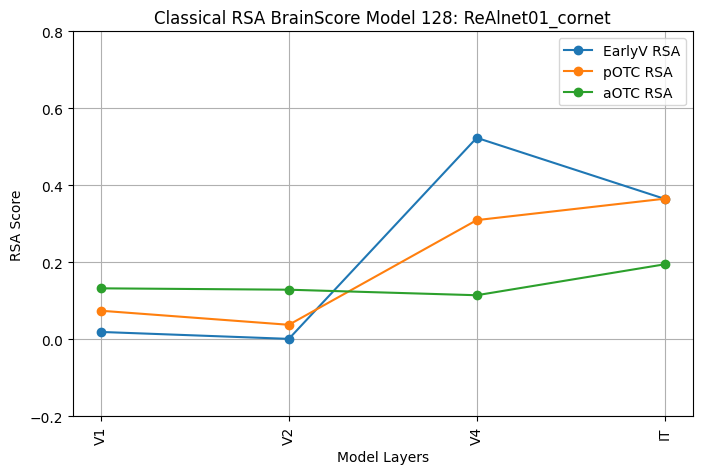

In [80]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_128_activations_regions.pt')

# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI using your RSA function.
# (Assuming compute_classical_rsa_from_activations is already defined.)
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Create a single figure for plotting
plt.figure(figsize=(8, 5))

# Optional: Define stop_layer if you want to truncate the layers.
# stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # If you want to truncate at a stop_layer, do so:
    if 'stop_layer' in locals() and stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]

    # Create an array of RSA values for these layers.
    # If a value is a tuple, extract its first element (e.g., the correlation value).
    correlation_values = np.array([
        rsa_values[layer][0] if isinstance(rsa_values[layer], tuple)
        else rsa_values[layer].detach().cpu().numpy()
        for layer in layers
    ])
    
    # If the result is 2D (multiple values per layer), extract only the first column.
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting the plot
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 128: ReAlnet01_cornet")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## 134: ReAlnet03_cornet

In [4]:
model = load_model("ReAlnet03_cornet")

  Cloning https://github.com/dicarlolab/CORnet.git to /tmp/pip-install-wgnvsjgq/cornet_99312834b0e54977a7618e8c63c6d888


  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet.git /tmp/pip-install-wgnvsjgq/cornet_99312834b0e54977a7618e8c63c6d888



  Resolved https://github.com/dicarlolab/CORnet.git to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [5]:
model_134 = model.activations_model._model
model_134

Sequential(
  (V1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin2): ReLU(inplace=True)
    (output): Identity()
  )
  (V2): CORblock_S(
    (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (nonlin1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, k

In [6]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
layers =["V1", "V2", "V4", "IT"]


model_134.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_134, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

V1 torch.Size([72, 64, 56, 56])
V2 torch.Size([72, 128, 28, 28])
V4 torch.Size([72, 256, 14, 14])
IT torch.Size([72, 512, 7, 7])


In [7]:
torch.save(activations, "model_134_activations_regions.pt")

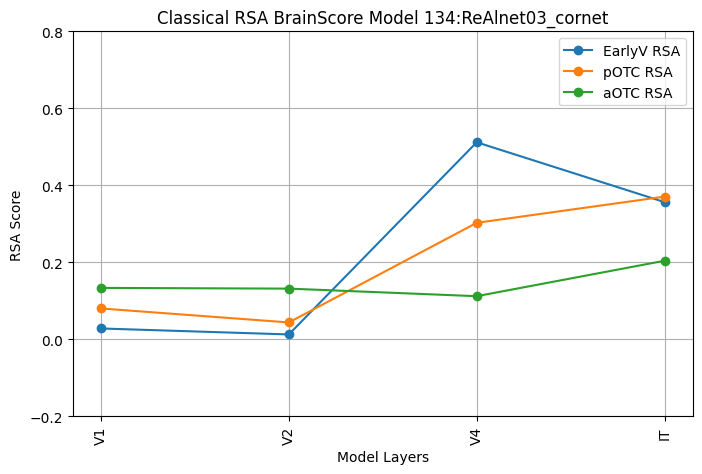

In [9]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_134_activations_regions.pt')

# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI using your RSA function.
# (Assuming compute_classical_rsa_from_activations is already defined.)
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Create a single figure for plotting
plt.figure(figsize=(8, 5))

# Optional: Define stop_layer if you want to truncate the layers.
# stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # If you want to truncate at a stop_layer, do so:
    if 'stop_layer' in locals() and stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]

    # Create an array of RSA values for these layers.
    # If a value is a tuple, extract its first element (e.g., the correlation value).
    correlation_values = np.array([
        rsa_values[layer][0] if isinstance(rsa_values[layer], tuple)
        else rsa_values[layer].detach().cpu().numpy()
        for layer in layers
    ])
    
    # If the result is 2D (multiple values per layer), extract only the first column.
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting the plot
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 134:ReAlnet03_cornet")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 123: ReAlnet07_cornet

In [10]:
model = load_model("ReAlnet07_cornet")

  Cloning https://github.com/dicarlolab/CORnet.git to /tmp/pip-install-u9nlbjhk/cornet_c932b909af52457b93e5982821d4083f


  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet.git /tmp/pip-install-u9nlbjhk/cornet_c932b909af52457b93e5982821d4083f



  Resolved https://github.com/dicarlolab/CORnet.git to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [11]:
model_123 = model.activations_model._model
model_123

Sequential(
  (V1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin2): ReLU(inplace=True)
    (output): Identity()
  )
  (V2): CORblock_S(
    (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (nonlin1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, k

In [12]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
layers =["V1", "V2", "V4", "IT"]


model_123.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_123, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

V1 torch.Size([72, 64, 56, 56])
V2 torch.Size([72, 128, 28, 28])
V4 torch.Size([72, 256, 14, 14])
IT torch.Size([72, 512, 7, 7])


In [13]:
torch.save(activations, "model_123_activations_regions.pt")

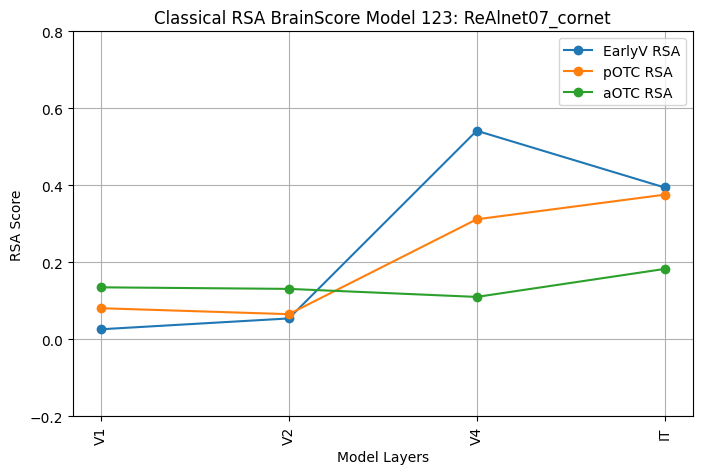

In [14]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_123_activations_regions.pt')

# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI using your RSA function.
# (Assuming compute_classical_rsa_from_activations is already defined.)
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Create a single figure for plotting
plt.figure(figsize=(8, 5))

# Optional: Define stop_layer if you want to truncate the layers.
# stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # If you want to truncate at a stop_layer, do so:
    if 'stop_layer' in locals() and stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]

    # Create an array of RSA values for these layers.
    # If a value is a tuple, extract its first element (e.g., the correlation value).
    correlation_values = np.array([
        rsa_values[layer][0] if isinstance(rsa_values[layer], tuple)
        else rsa_values[layer].detach().cpu().numpy()
        for layer in layers
    ])
    
    # If the result is 2D (multiple values per layer), extract only the first column.
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting the plot
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 123: ReAlnet07_cornet")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 115: ReAlnet10_cornet

In [15]:
model = load_model("ReAlnet10_cornet")

  Cloning https://github.com/dicarlolab/CORnet.git to /tmp/pip-install-0cc0nhzs/cornet_cc5df97667024a6a82a679ec881c1c53


  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet.git /tmp/pip-install-0cc0nhzs/cornet_cc5df97667024a6a82a679ec881c1c53



  Resolved https://github.com/dicarlolab/CORnet.git to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [16]:
model_115 = model.activations_model._model
model_115

Sequential(
  (V1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin2): ReLU(inplace=True)
    (output): Identity()
  )
  (V2): CORblock_S(
    (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (nonlin1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, k

In [17]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
layers =["V1", "V2", "V4", "IT"]


model_115.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_115, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

V1 torch.Size([72, 64, 56, 56])
V2 torch.Size([72, 128, 28, 28])
V4 torch.Size([72, 256, 14, 14])
IT torch.Size([72, 512, 7, 7])


In [18]:
torch.save(activations, "model_115_activations_regions.pt")

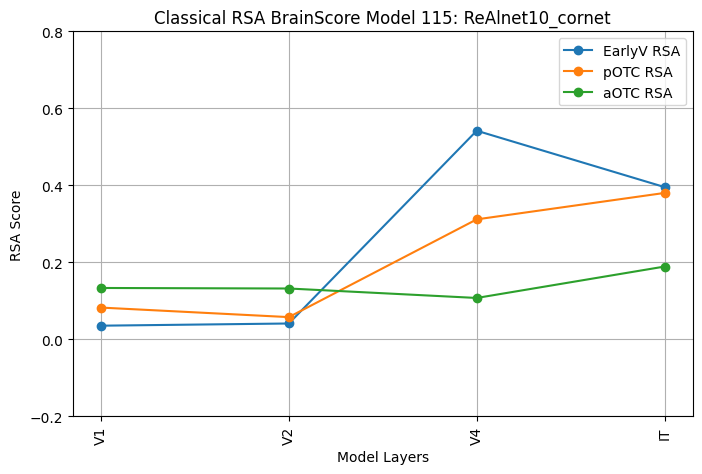

In [19]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_115_activations_regions.pt')

# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI using your RSA function.
# (Assuming compute_classical_rsa_from_activations is already defined.)
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Create a single figure for plotting
plt.figure(figsize=(8, 5))

# Optional: Define stop_layer if you want to truncate the layers.
# stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # If you want to truncate at a stop_layer, do so:
    if 'stop_layer' in locals() and stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]

    # Create an array of RSA values for these layers.
    # If a value is a tuple, extract its first element (e.g., the correlation value).
    correlation_values = np.array([
        rsa_values[layer][0] if isinstance(rsa_values[layer], tuple)
        else rsa_values[layer].detach().cpu().numpy()
        for layer in layers
    ])
    
    # If the result is 2D (multiple values per layer), extract only the first column.
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting the plot
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 115: ReAlnet10_cornet")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()


## Model 118:ReAlnet08_cornet

In [20]:
model = load_model("ReAlnet08_cornet")

  Cloning https://github.com/dicarlolab/CORnet.git to /tmp/pip-install-ze9eki9j/cornet_a218960c854445a4a5730cb6c96d5b49


  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet.git /tmp/pip-install-ze9eki9j/cornet_a218960c854445a4a5730cb6c96d5b49



  Resolved https://github.com/dicarlolab/CORnet.git to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [21]:
model_118 = model.activations_model._model
model_118

Sequential(
  (V1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin1): ReLU(inplace=True)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (nonlin2): ReLU(inplace=True)
    (output): Identity()
  )
  (V2): CORblock_S(
    (conv_input): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (skip): Conv2d(128, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (norm_skip): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (nonlin1): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, k

In [22]:
# block 0-23
dataset_path = "s3://visionlab-litdata/exploring-objects-images/"
imgs = load_data(dataset_path, image_size=224)

import neuroai_kit as nk

#layers = layers = [f"features.{i}" for i in range(13)]

 # 0- n-1, since there are 0-23 range is 24
layers =["V1", "V2", "V4", "IT"]


model_118.eval()
with torch.no_grad():    
    with nk.NeuroElectrodeArray(model_118, layers) as electrode:
        activations = electrode(imgs)
for layer_name, act in activations.items():
    print(layer_name, act.shape)

V1 torch.Size([72, 64, 56, 56])
V2 torch.Size([72, 128, 28, 28])
V4 torch.Size([72, 256, 14, 14])
IT torch.Size([72, 512, 7, 7])


In [23]:
torch.save(activations, "model_118_activations_regions.pt")

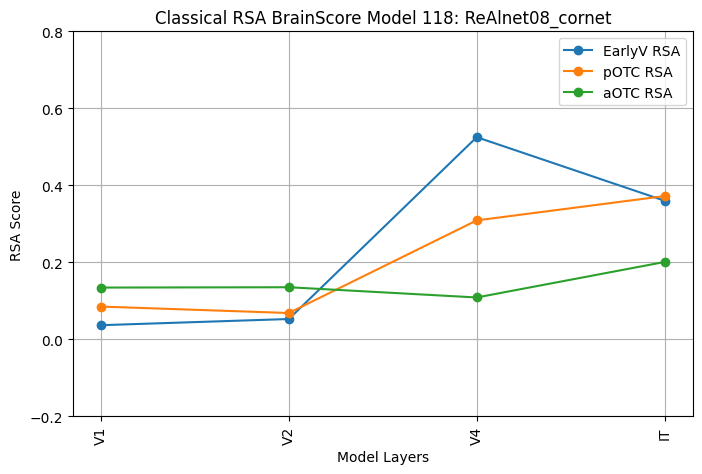

In [24]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform

# load activations 
activations = torch.load('model_118_activations_regions.pt')

# Specifying ROIs
rois = ['EarlyV', 'pOTC', 'aOTC']
roi_rdms = {}
for roi in rois:
    with open(f"avg_brain_rdms/{roi}_avg_rdm.pkl", 'rb') as f:
        roi_rdms[roi] = pickle.load(f)

# Compute RSA for each ROI using your RSA function.
# (Assuming compute_classical_rsa_from_activations is already defined.)
rsa_results = {
    roi: compute_classical_rsa_from_activations(roi_rdms[roi], activations)
    for roi in rois
}

# Create a single figure for plotting
plt.figure(figsize=(8, 5))

# Optional: Define stop_layer if you want to truncate the layers.
# stop_layer = "model.base_arch.projector.layers.fc_block_8.0"

for roi, rsa_values in rsa_results.items():
    # Get layer names from the dictionary keys
    layers = list(rsa_values.keys())
    
    # If you want to truncate at a stop_layer, do so:
    if 'stop_layer' in locals() and stop_layer in layers:
        stop_index = layers.index(stop_layer) + 1  # +1 to include that layer
        layers = layers[:stop_index]

    # Create an array of RSA values for these layers.
    # If a value is a tuple, extract its first element (e.g., the correlation value).
    correlation_values = np.array([
        rsa_values[layer][0] if isinstance(rsa_values[layer], tuple)
        else rsa_values[layer].detach().cpu().numpy()
        for layer in layers
    ])
    
    # If the result is 2D (multiple values per layer), extract only the first column.
    if correlation_values.ndim == 2:
        correlation_values = correlation_values[:, 0]
    
    # Plot the line for this ROI
    plt.plot(layers, correlation_values, marker='o', label=f"{roi} RSA")

# Formatting the plot
plt.xlabel("Model Layers")
plt.ylabel("RSA Score")
plt.ylim(-0.2, 0.8)
plt.title("Classical RSA BrainScore Model 118: ReAlnet08_cornet")
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()
